In [25]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

In [3]:
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


## Loading data set

Scanpy includes a processed PBMC dataset that we will use

In [4]:
pbmc = sc.datasets.pbmc68k_reduced()

In [5]:
# inspect pbmc contents
pbmc

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization of Gene Expression and other variables

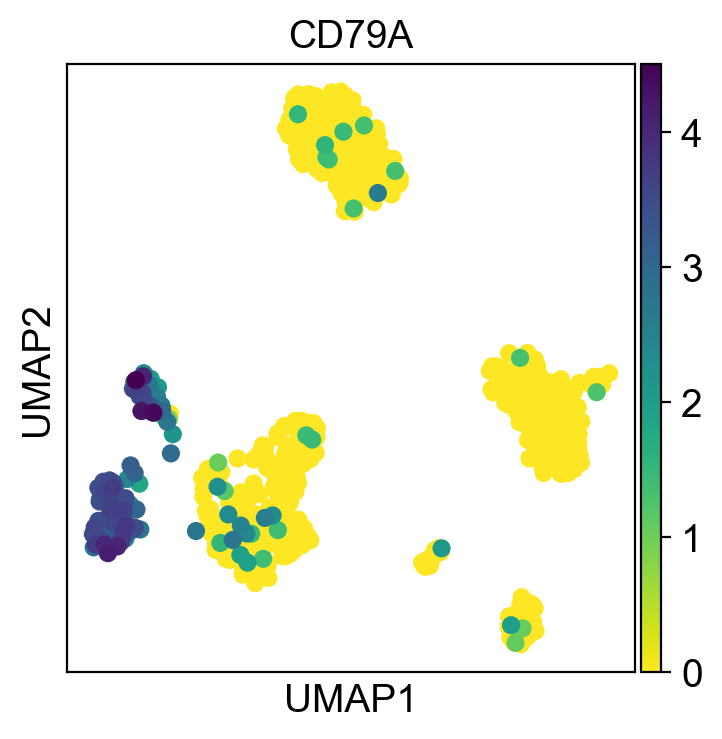

In [6]:
# rc_context is used for the figure size in this case 4x4
with rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(pbmc, color="CD79A")

For scatter plots the value is given in the color argument. this can be any gene or any column in .obs where .obs is the data fram containging annotations per obeservation/cell

Multiple values can be given to color

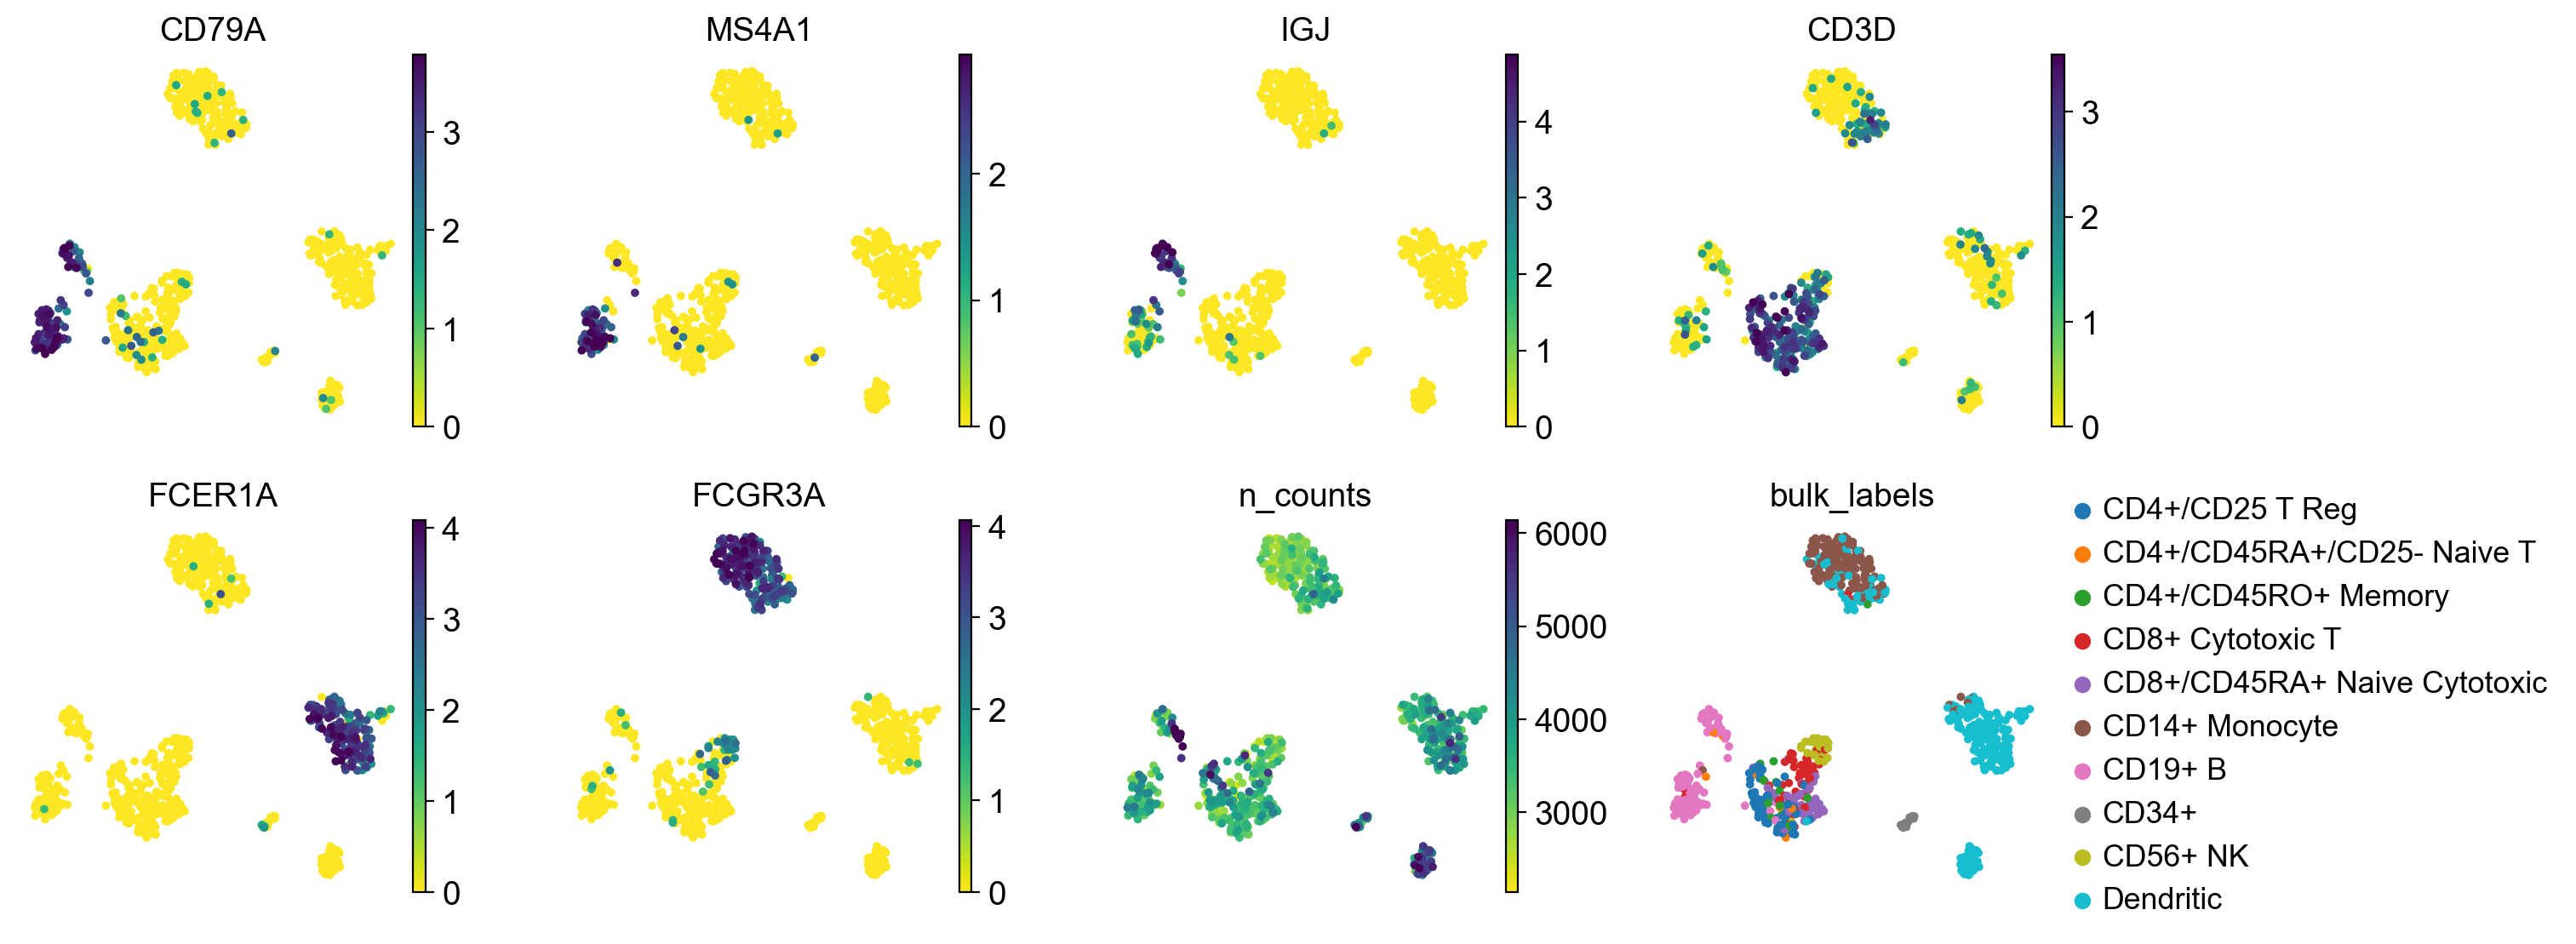

In [7]:
color_vars = [
    "CD79A",
    "MS4A1",
    "IGJ",
    "CD3D",
    "FCER1A",
    "FCGR3A",
    "n_counts",
    "bulk_labels",
]

with rc_context({"figure.figsize": (3,3)}):
    sc.pl.umap(pbmc, color=color_vars, s=50, frameon=False, ncols=4, vmax="p99")

Multiple values can be given to color so using the list of 6 genes we can make 6 plots to show where the marker genes are being expressed

Additionally n_counts shows the number of UMI counts per cell, and bulk_labels shows the categorical value containing the original labelling of the cells from 10X

the ncols argument controlls the number of plots per row. 

the maximum value plotted is adjusted using vmax(vmin for minimum), in this case we used p99 which means to use the 99th percentile as the max value. The max value can also be a number or a list if the vmax needs to be set for individual plots

Frameon=False removes the boxes around each plot

s = 50 sets the dot size for the plots

In the plots we can see groups of cells that express marker genes and the agreement with the original cell labels

In [8]:
#compute clusters using the leiden method and stroe the result with the name 'clusters'

sc.tl.leiden(
    pbmc,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    directed=False,
)

C:\Users\chpar\AppData\Local\Temp\ipykernel_13936\1932767322.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Error given when using the igraph flavour

Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "numpy\\random\\mtrand.pyx", line 780, in numpy.random.mtrand.RandomState.randint
  File "numpy\\random\\_bounded_integers.pyx", line 2881, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32

Additional, CPU usage goes to 100% when running, program becomes unresponsive an must be fore quit using task manager

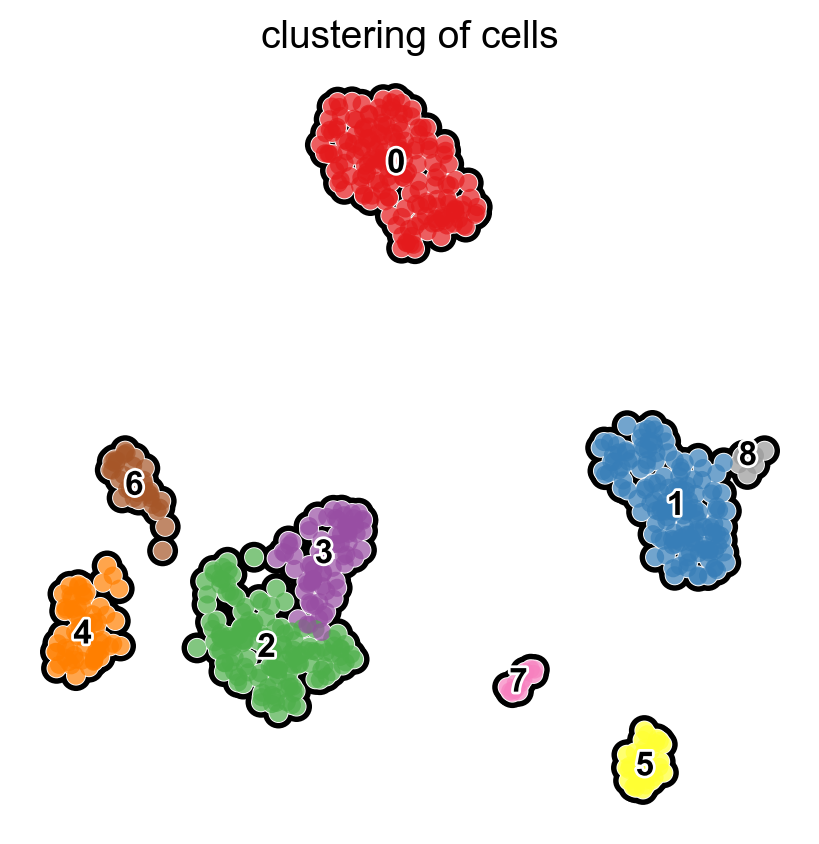

In [10]:
with rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

## Identification of clusters based on known marker genes

Cluster often need to be labelled using known marker genes

Using scatter plots we can see the expression of a gene and perhaps associate it with a cluster

Alternative methods to associate marker geenes to clusters use dotplots, violin plots, heatmaps, and tracksplots

All methods show expression split by cluster

In [11]:
#Dictionary of marker genes

marker_genes_dict = {
    "B-cell": ["CD79A", "MS4A1"],
    "Dendritic": ["FCER1A", "CST3"],
    "Monocytes": ["FCGR3A"],
    "NK": ["GNLY", "NKG7"],
    "Other": ["IGLL1"],
    "Plasma": ["IGJ"],
    "T-cell": ["CD3D"],
}

## Dotplots:
the color represents the mean expression withiin each of the categories
the size indicates the fraction of cells in the categories expressing a gene

Dendrogram is used to bring together similar clusers

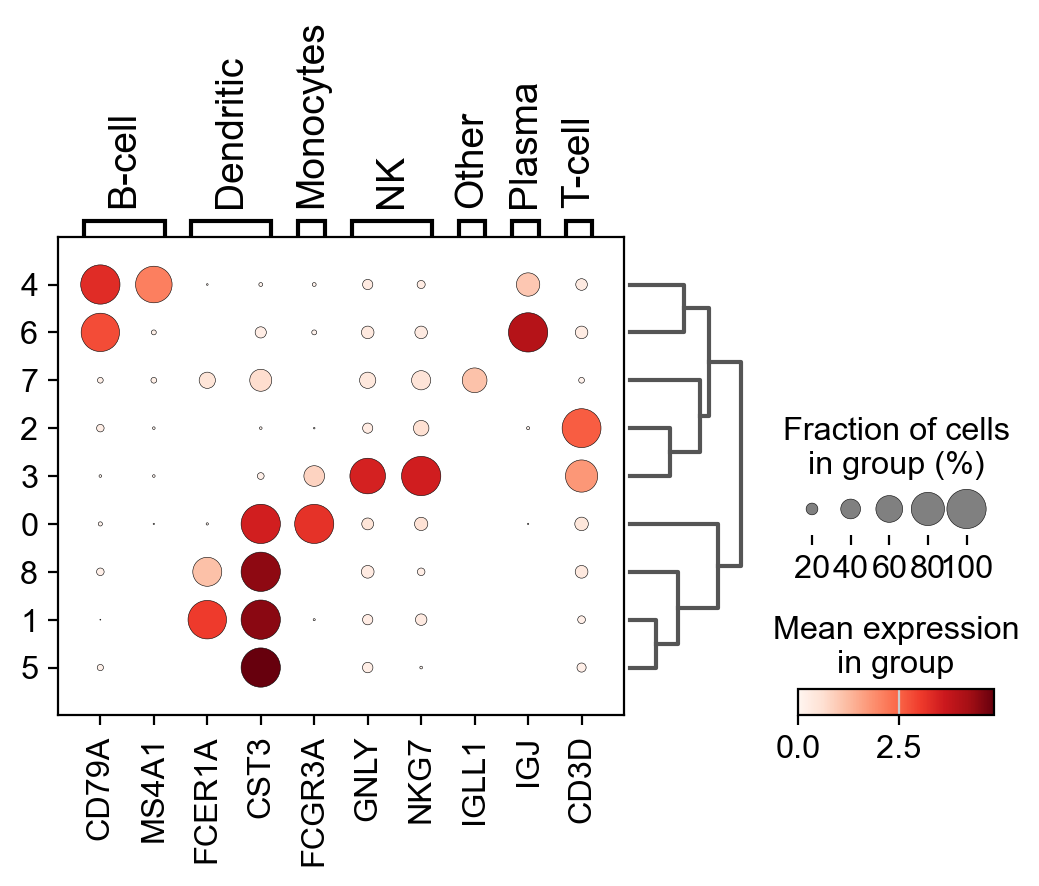

In [14]:
sc.pl.dotplot(pbmc, marker_genes_dict, "clusters", dendrogram=True)

Using this plot we can see the cluster 4 corresponds to B-cells, cluster 2 is T-cells, etc

We can them manually annotate the clusters 

In [15]:
# create a dictionary to map cluster to annotation label
cluster2annotation ={
    "0": "Monocytes",
    "1": "Dendritic",
    "2": "T-cell",
    "3": "NK",
    "4": "B-cell",
    "5": "Dendritic",
    "6": "Plasma",
    "7": "Other",
    "8": "Dendritic",
}

#add a new '.obs' column called 'cell type' bny making clusters to annotatiuon using pandas 'map'
pbmc.obs["cell type"] = pbmc.obs["clusters"].map(cluster2annotation).astype("category")

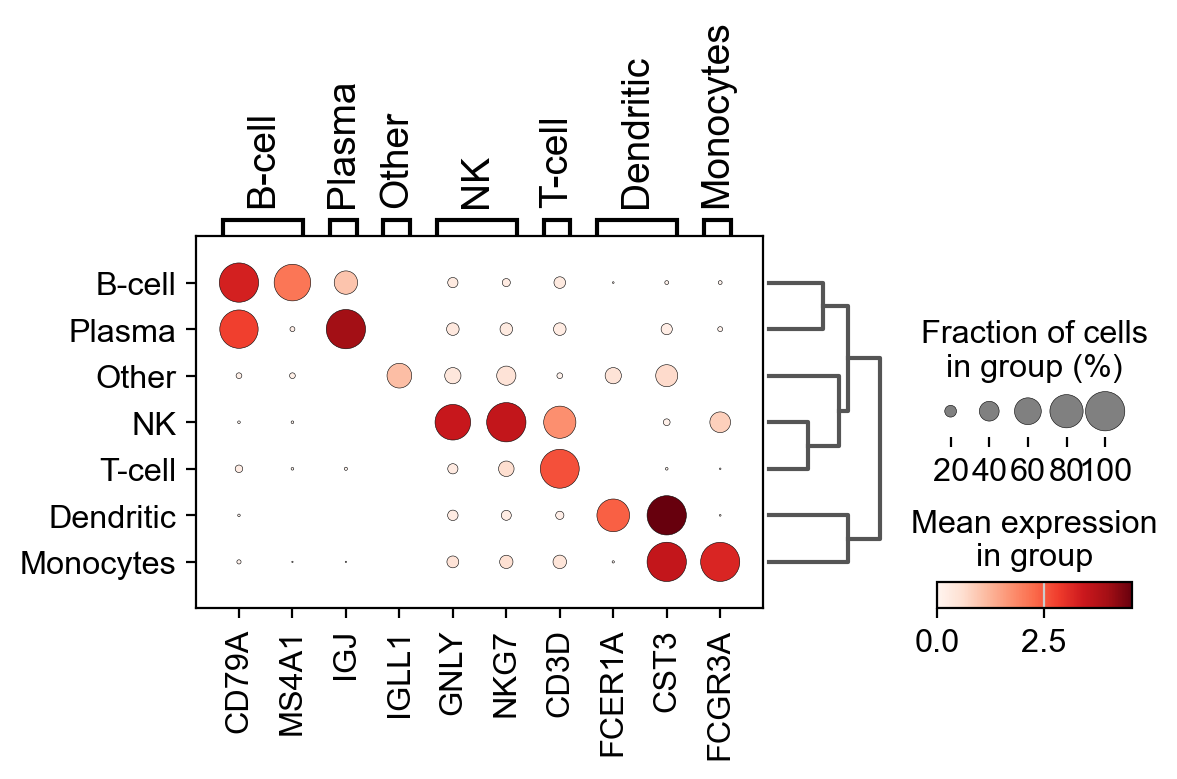

In [16]:
sc.pl.dotplot(pbmc, marker_genes_dict, "cell type", dendrogram=True)

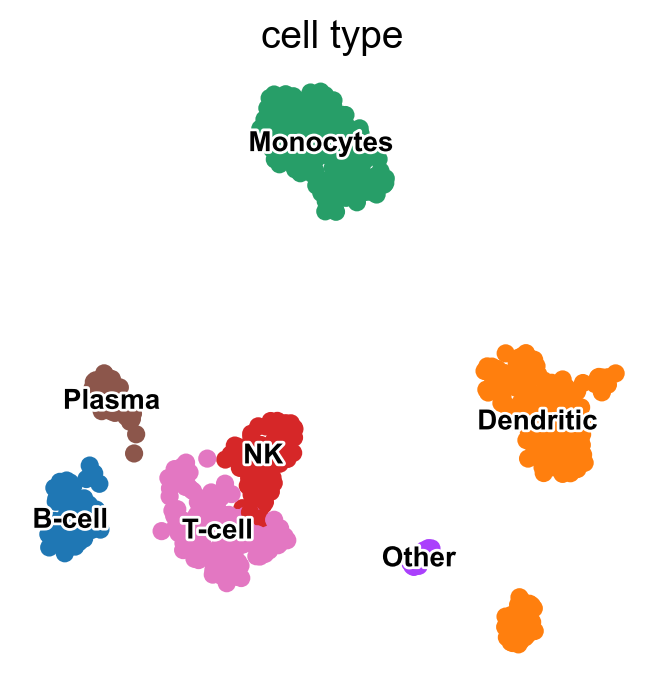

In [17]:
sc.pl.umap(
    pbmc,
    color="cell type",
    legend_loc="on data",
    frameon=False,
    legend_fontsize=10,
    legend_fontoutline=2
)

## Violin Plots

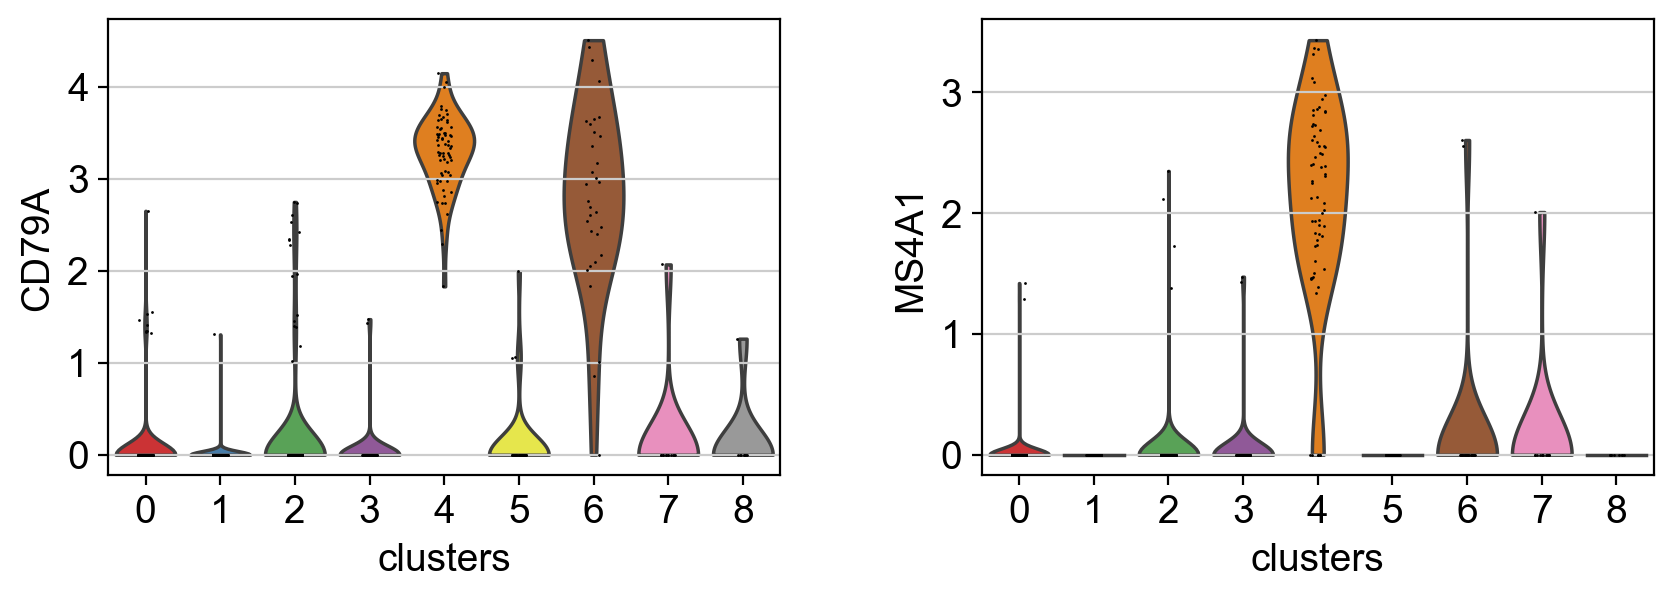

In [18]:
with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(pbmc, ["CD79A", "MS4A1"], groupby="clusters")

Here we see the expression of CD79A in clusters 4 and 6. Compared to dotplot the violin gives us an idea of gene distibution across cells

Violins can be used so plot any numerical value stored in .obs

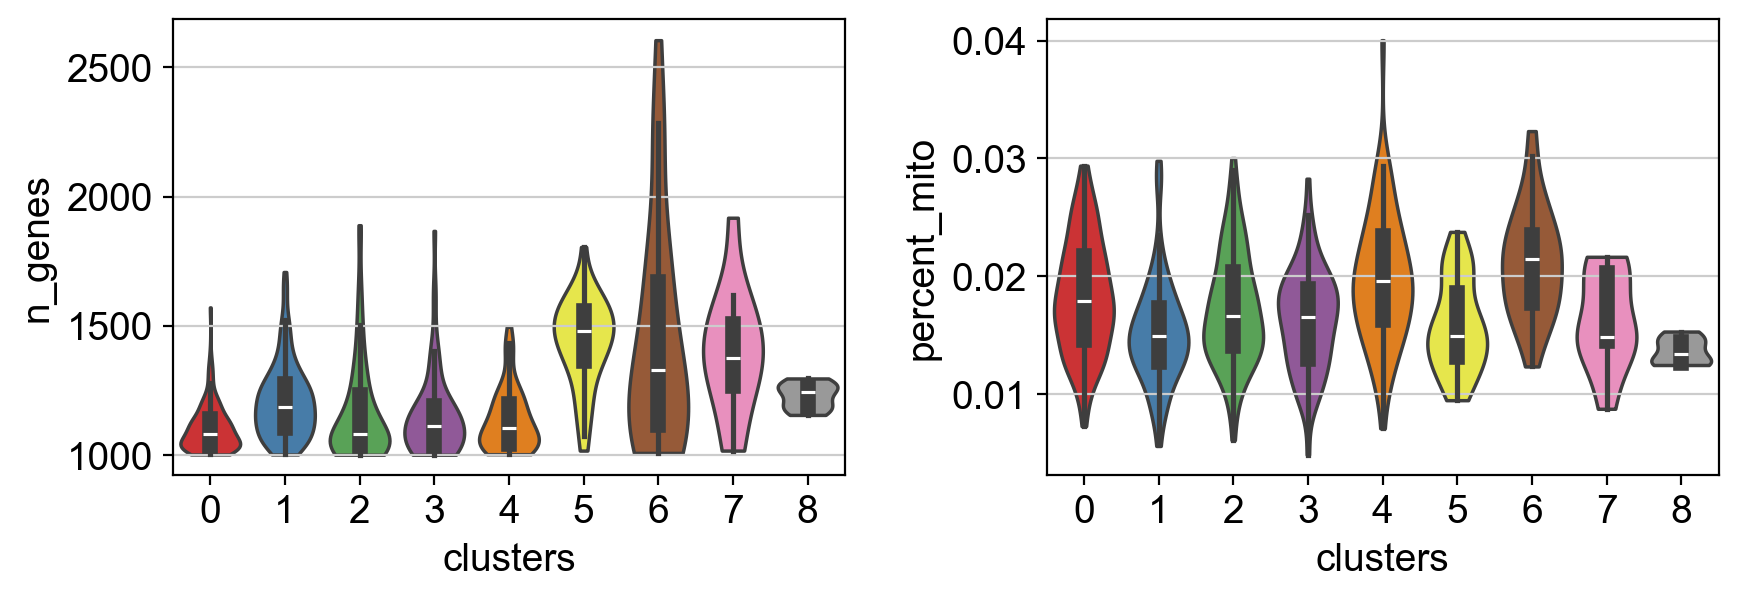

In [19]:
with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(
        pbmc,
        ["n_genes", "percent_mito"],
        groupby="clusters",
        stripplot=False, #remove the internal dots
        inner="box" # adds a boxplot inside violins

    )

#### Stacked Violin Plot

To look at all of the marker genes we can use a stacked violin plot

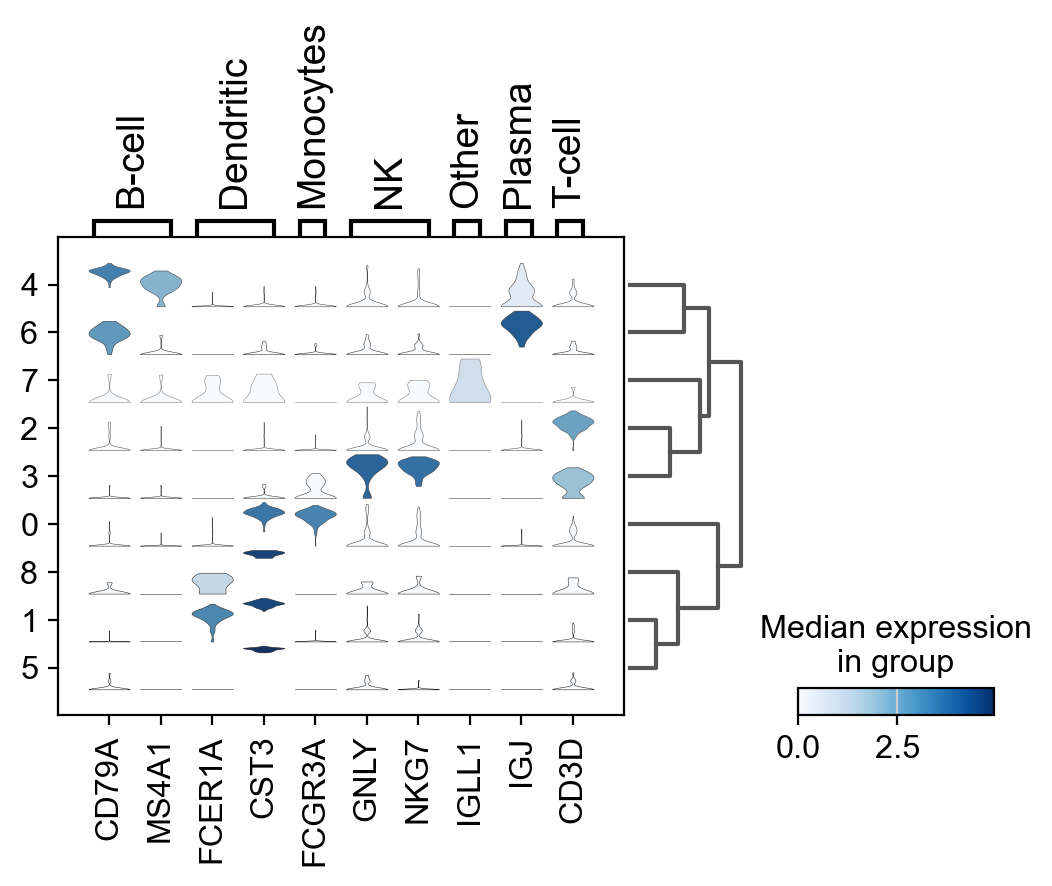

In [20]:
ax = sc.pl.stacked_violin(
    pbmc, marker_genes_dict, groupby="clusters", swap_axes=False, dendrogram=True
)

## Matrix Plot

Matrix plots are a heatmap of mean expression values per gene grouped by categories. This plot shows the same information as the color in dotplots

Gene expression is scaled between 0 and 1 with 11 being the maximum mean expression and 0 being the minimum

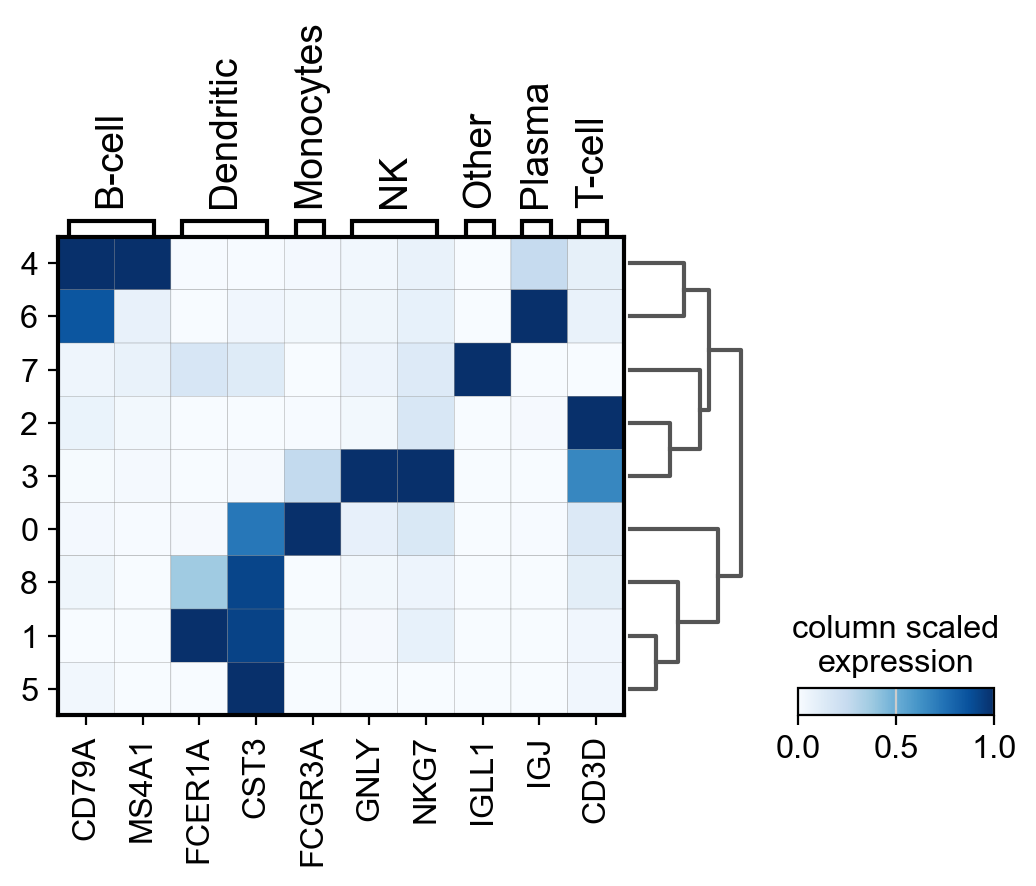

In [21]:
sc.pl.matrixplot(
    pbmc,
    marker_genes_dict,
    "clusters",
    dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    
)

Another option is the normalize the gene expression usiing sc.pp.scale

HEre the information is stored in the scale layer

After we adjust the plot min and max and use a diverging color map

In [22]:
#scale and store ssults in layer
pbmc.layers["scaled"] = sc.pp.scale(pbmc, copy=True).X

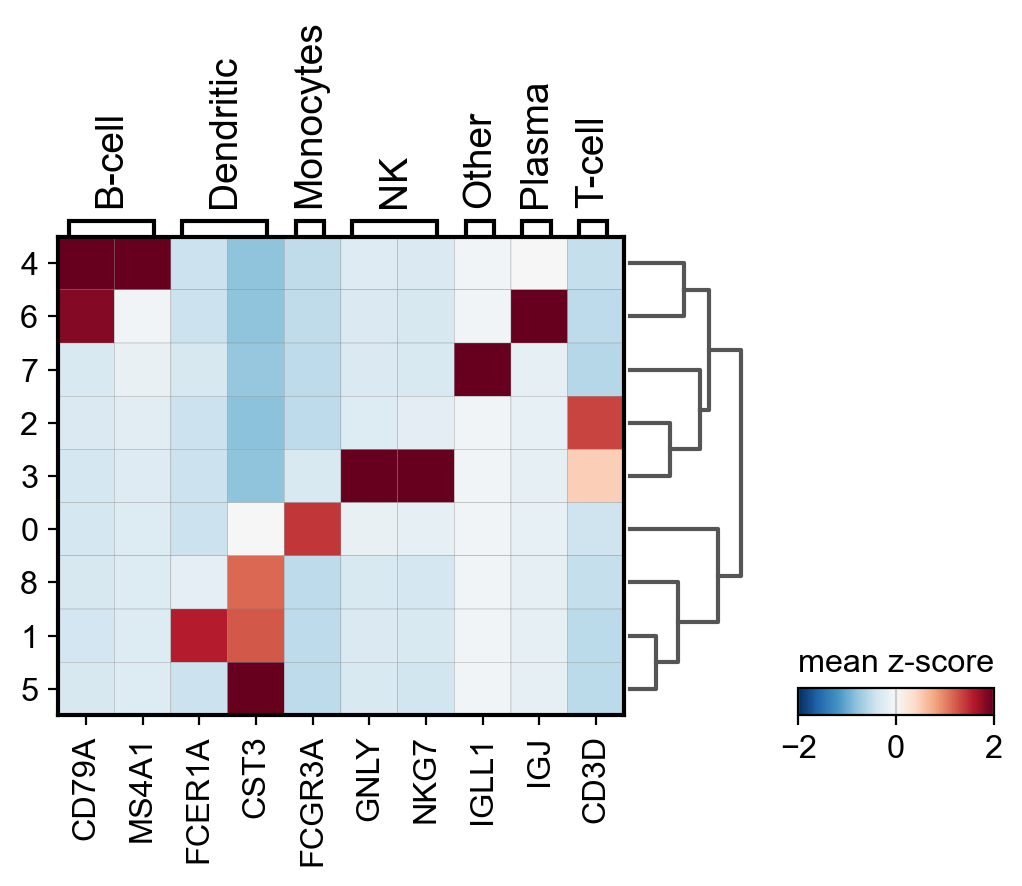

In [24]:
sc.pl.matrixplot(
    pbmc,
    marker_genes_dict,
    "clusters",
    dendrogram=True,
    colorbar_title="mean z-score",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",

)

## Combining plots in subplots

An axis can be passed to a plot to combine multiple outputs

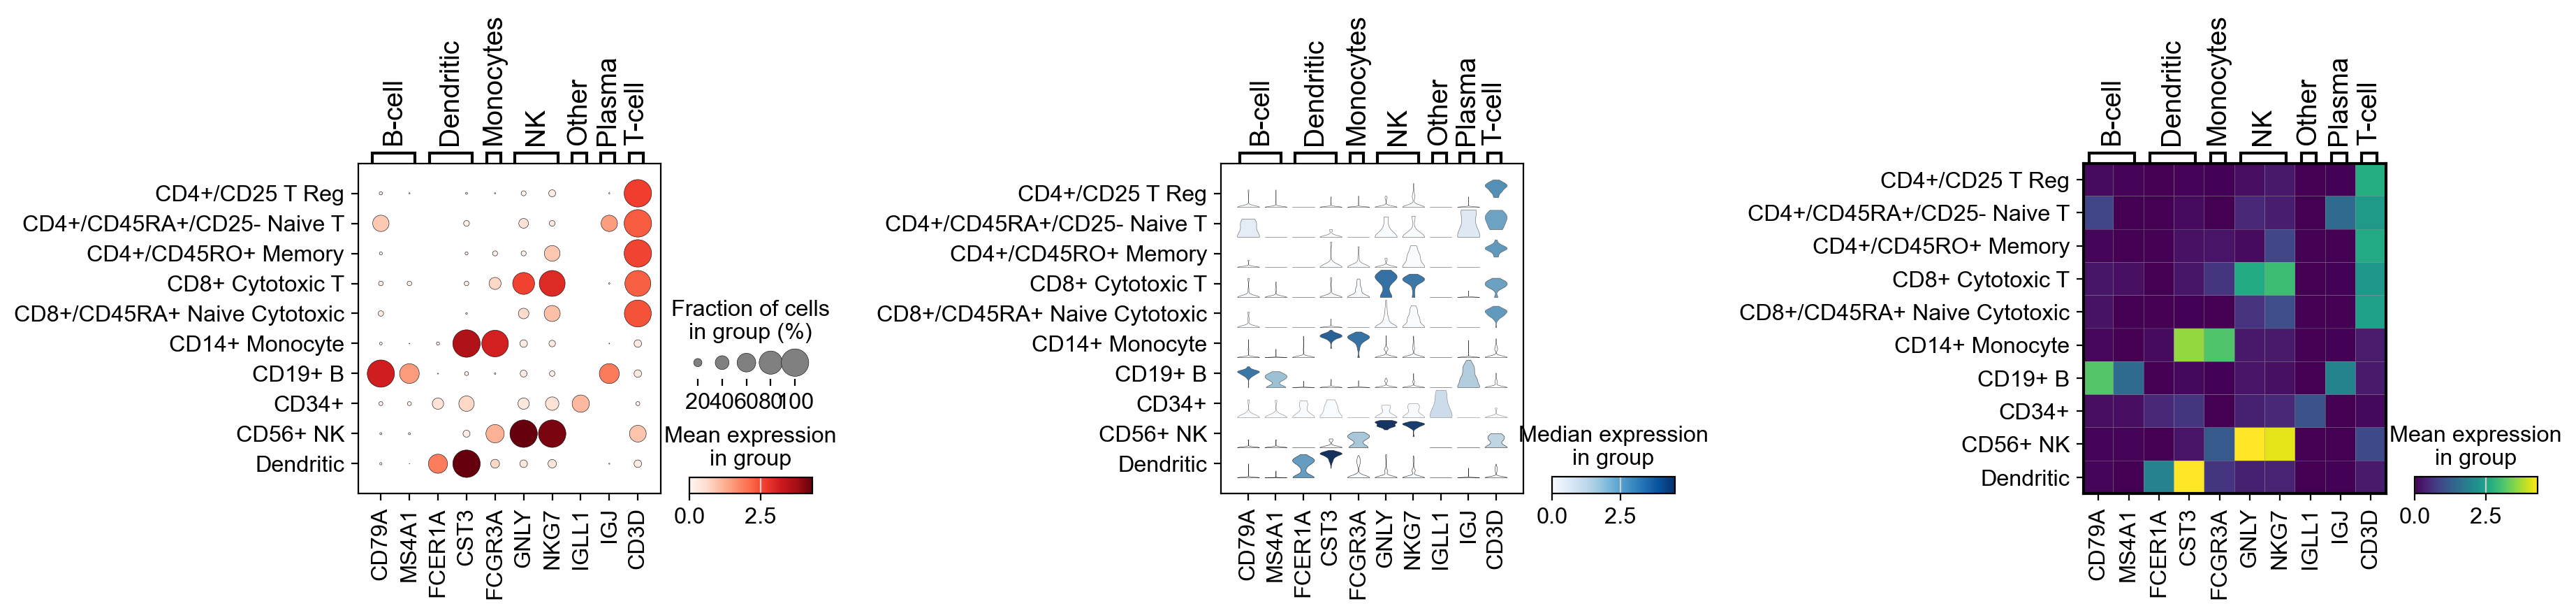

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4), gridspec_kw={"wspace": 0.9})

ax1_dict = sc.pl.dotplot(
    pbmc, marker_genes_dict , groupby="bulk_labels", ax=ax1, show=False
)
ax2_dict = sc.pl.stacked_violin(
    pbmc, marker_genes_dict , groupby="bulk_labels", ax=ax2, show=False
)
ax3_dict = sc.pl.matrixplot(
    pbmc, marker_genes_dict , groupby="bulk_labels", ax=ax3, show=False
)

## Heat Maps

Heat maps show each cell in a row(or column if swap_axes=True) and iis shown in the same colour code found in sc.pl.umap

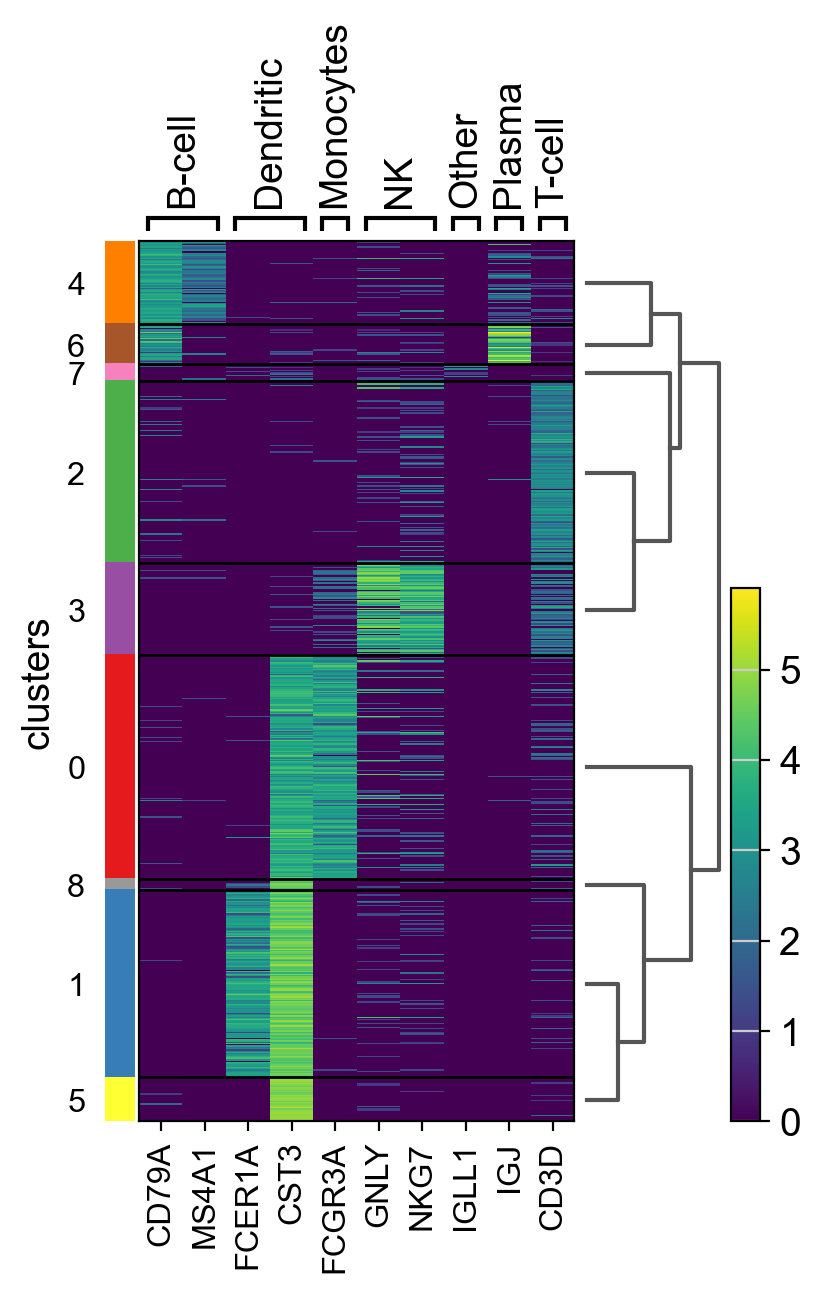

In [28]:
ax = sc.pl.heatmap(
    pbmc, marker_genes_dict, groupby="clusters", cmap="viridis", dendrogram=True
)

The heatmap can also be plotted on scaled data as below

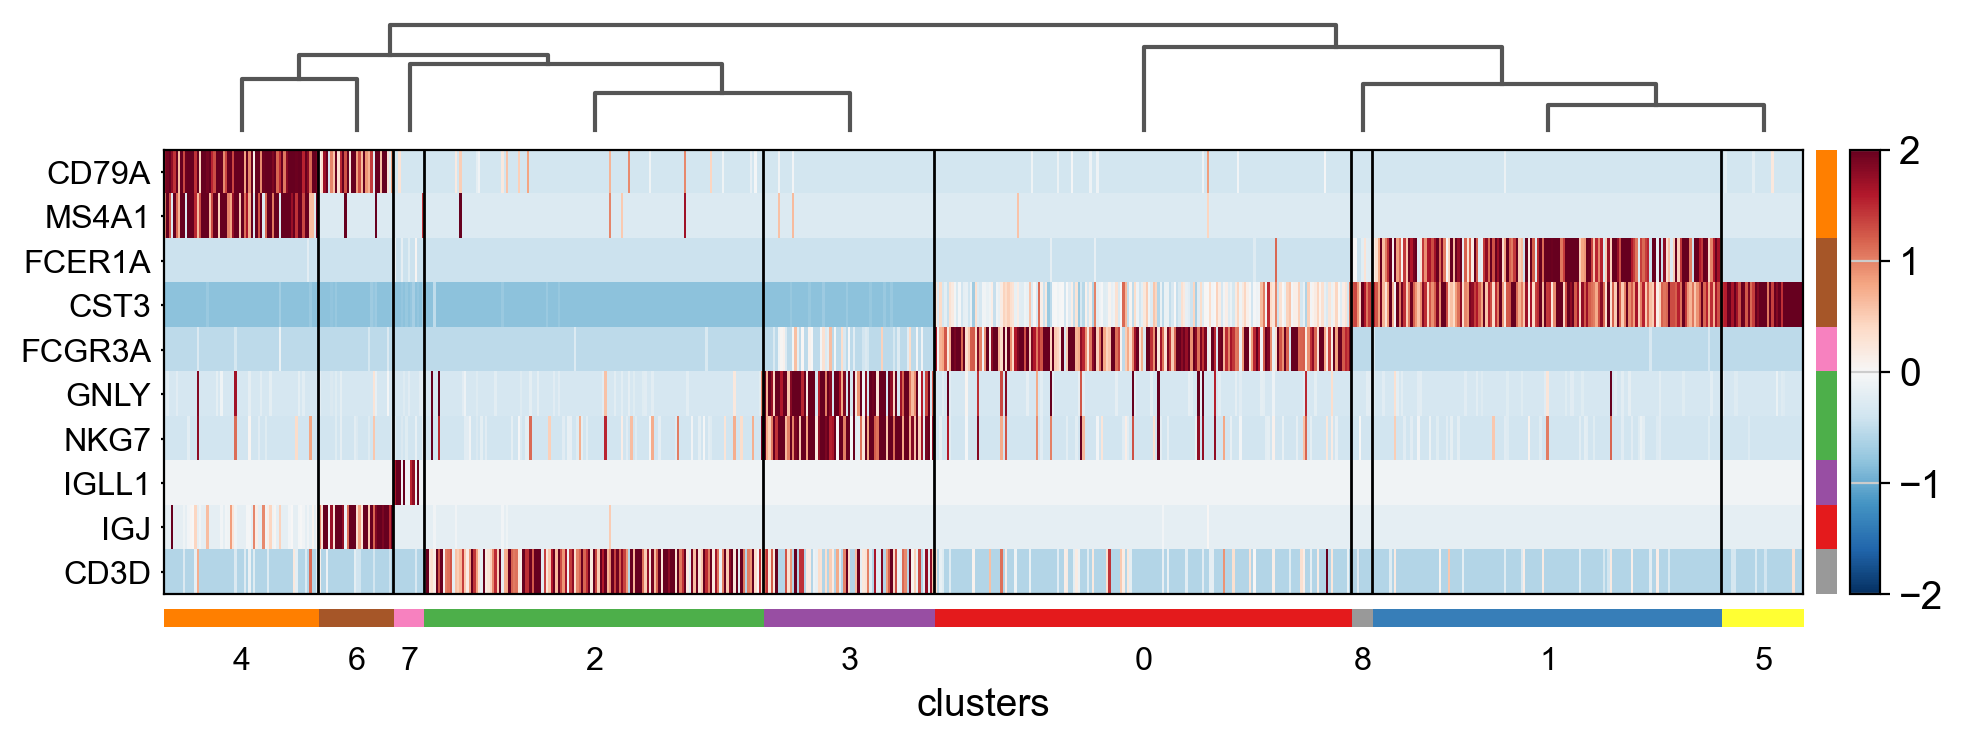

In [30]:
ax = sc.pl.heatmap(
    pbmc,
    marker_genes_dict,
    groupby="clusters",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11,4),

)

## Tracksplot

A tracksplot shows the same information as a heatmap but instead of a color scale, the gene expression is represented by height

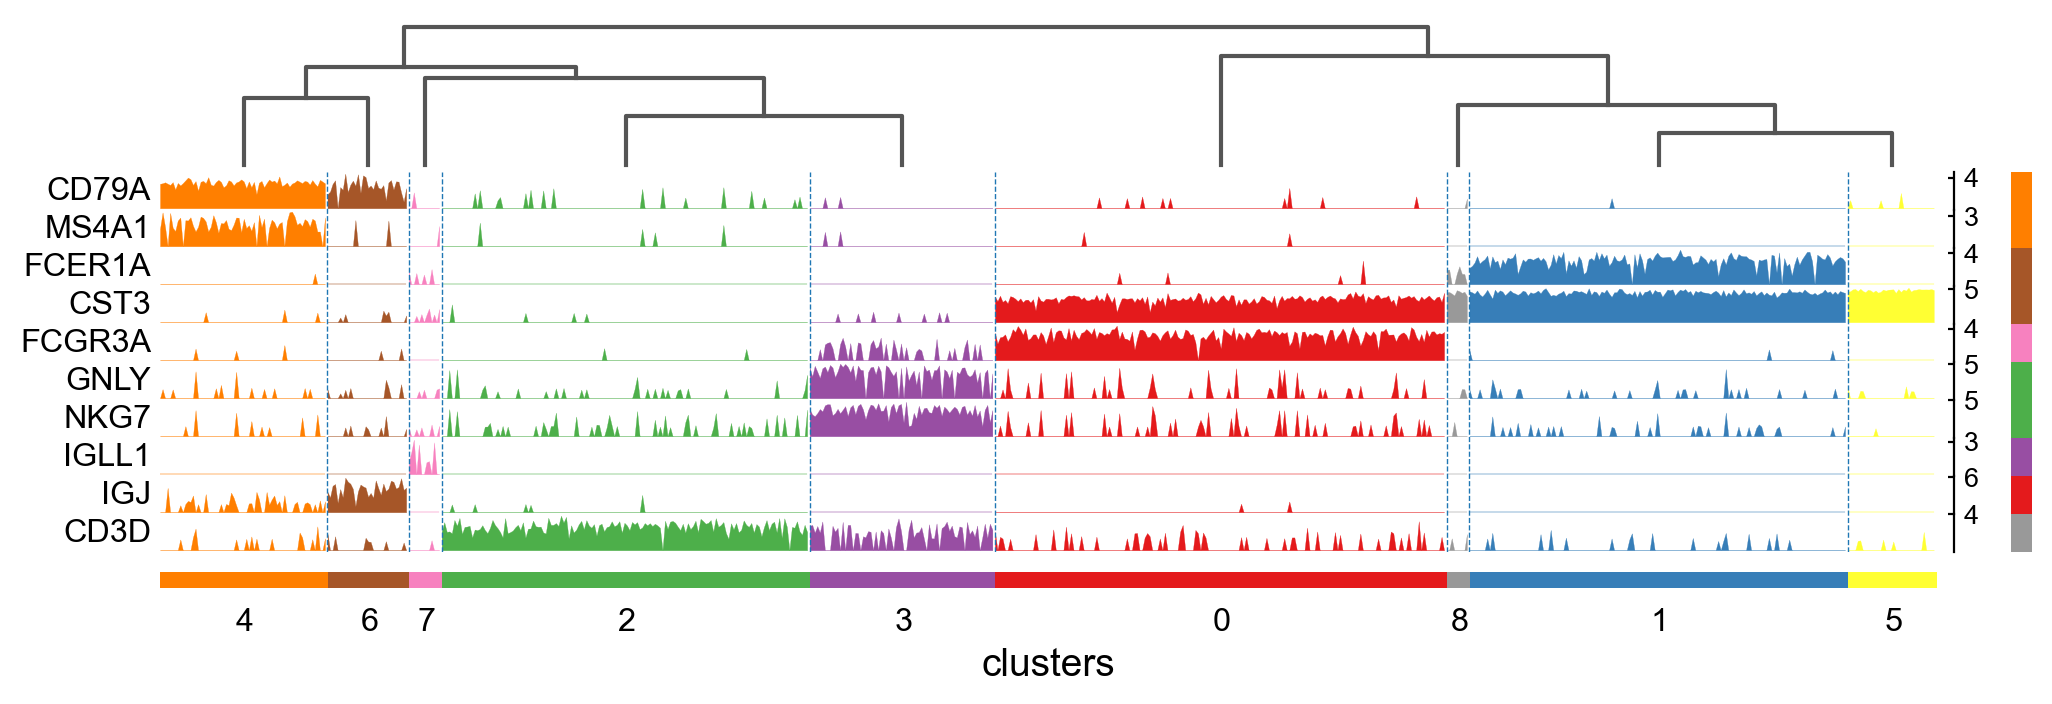

In [31]:
ax = sc.pl.tracksplot(pbmc, marker_genes_dict, groupby="clusters", dendrogram=True)

## Visualization of Marker genes

Instead of characterizing clusters by known gene markkers we can identify genes that are differentially expressed in the cluster

The function below compares the distribution of each gene in a group against the distribution in all cells not in the group

In [32]:
sc.tl.rank_genes_groups(pbmc, groupby="clusters", method="wilcoxon")

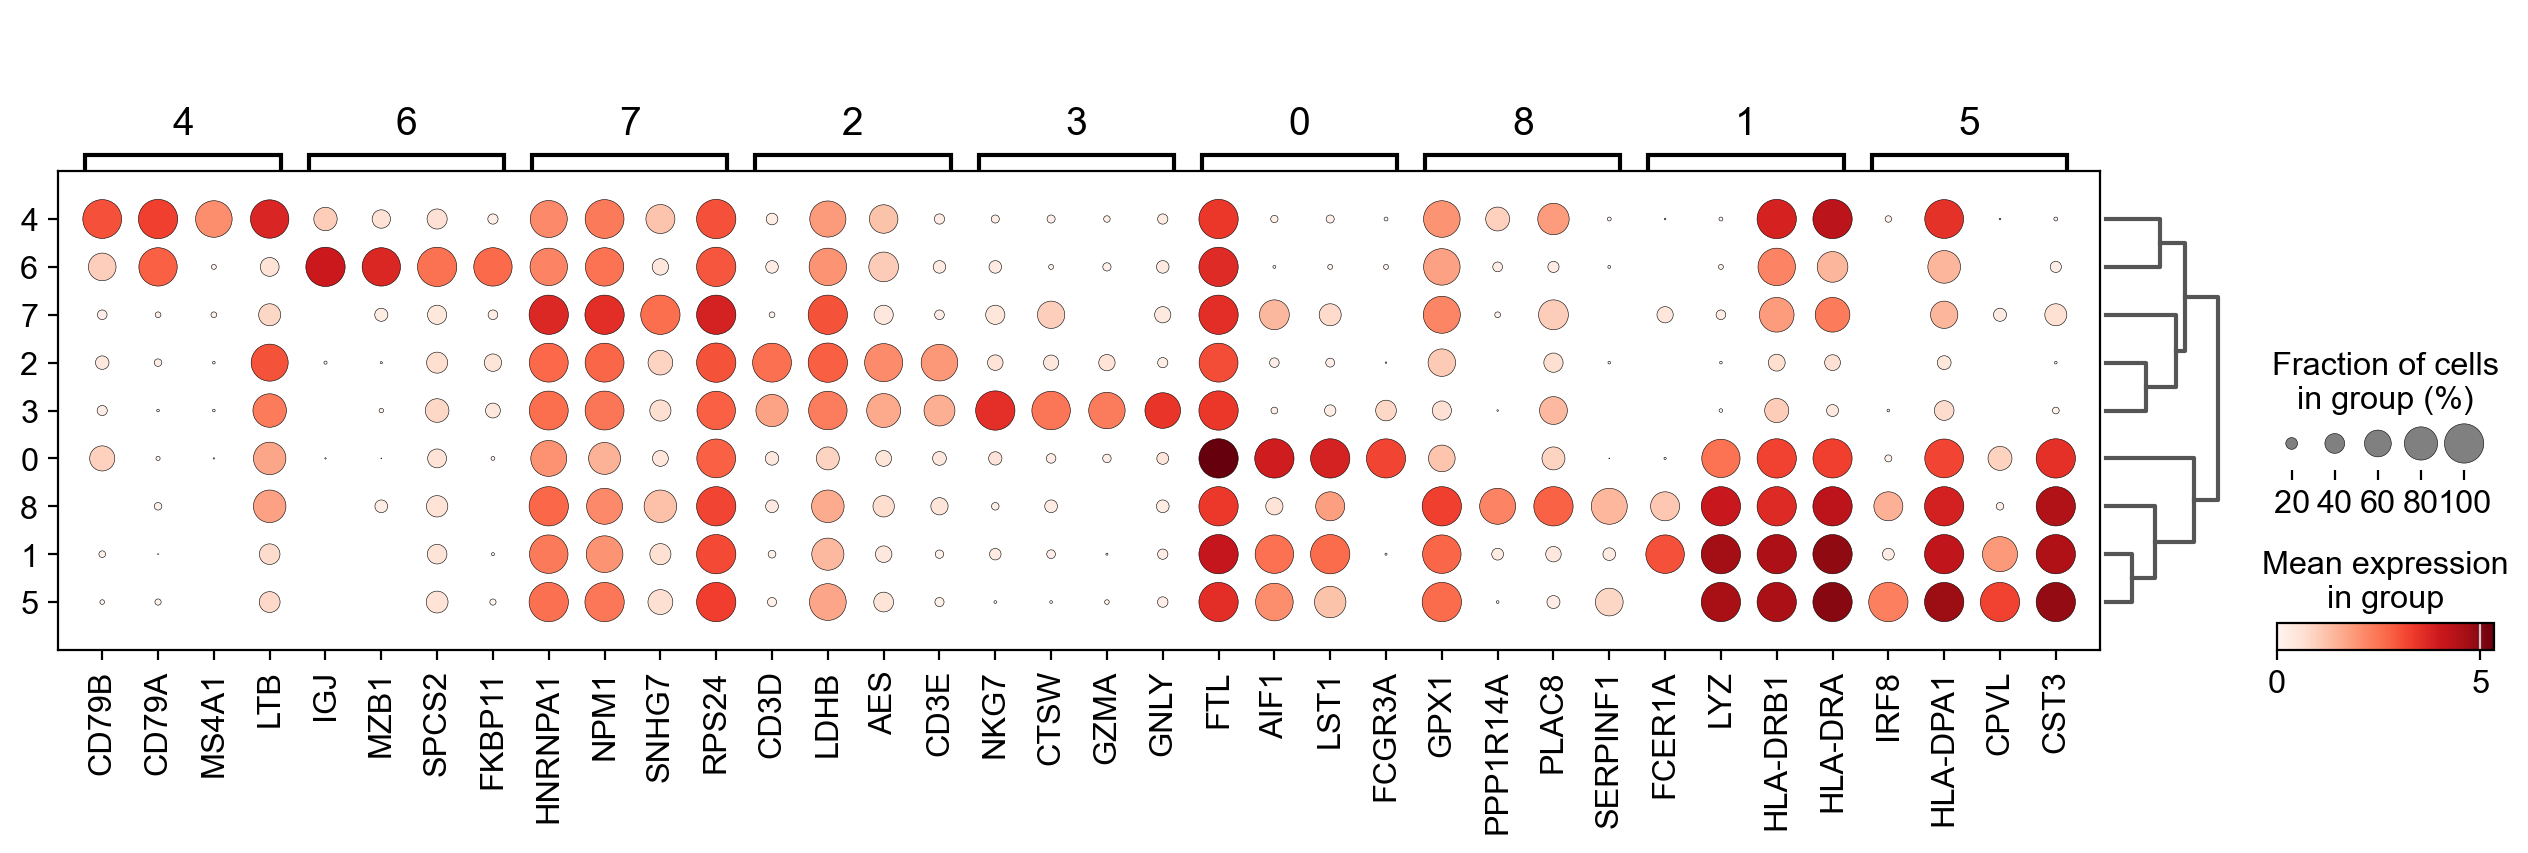

In [33]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)

The dotplot gives an overview of genes that show differential expression. 
The n_genes argument limits the top four scoring genes

In order to get a better representation we can polot log fold changes instead of gene expression

Because log fold change is divergent we adjust min and max and use a divergent colour map

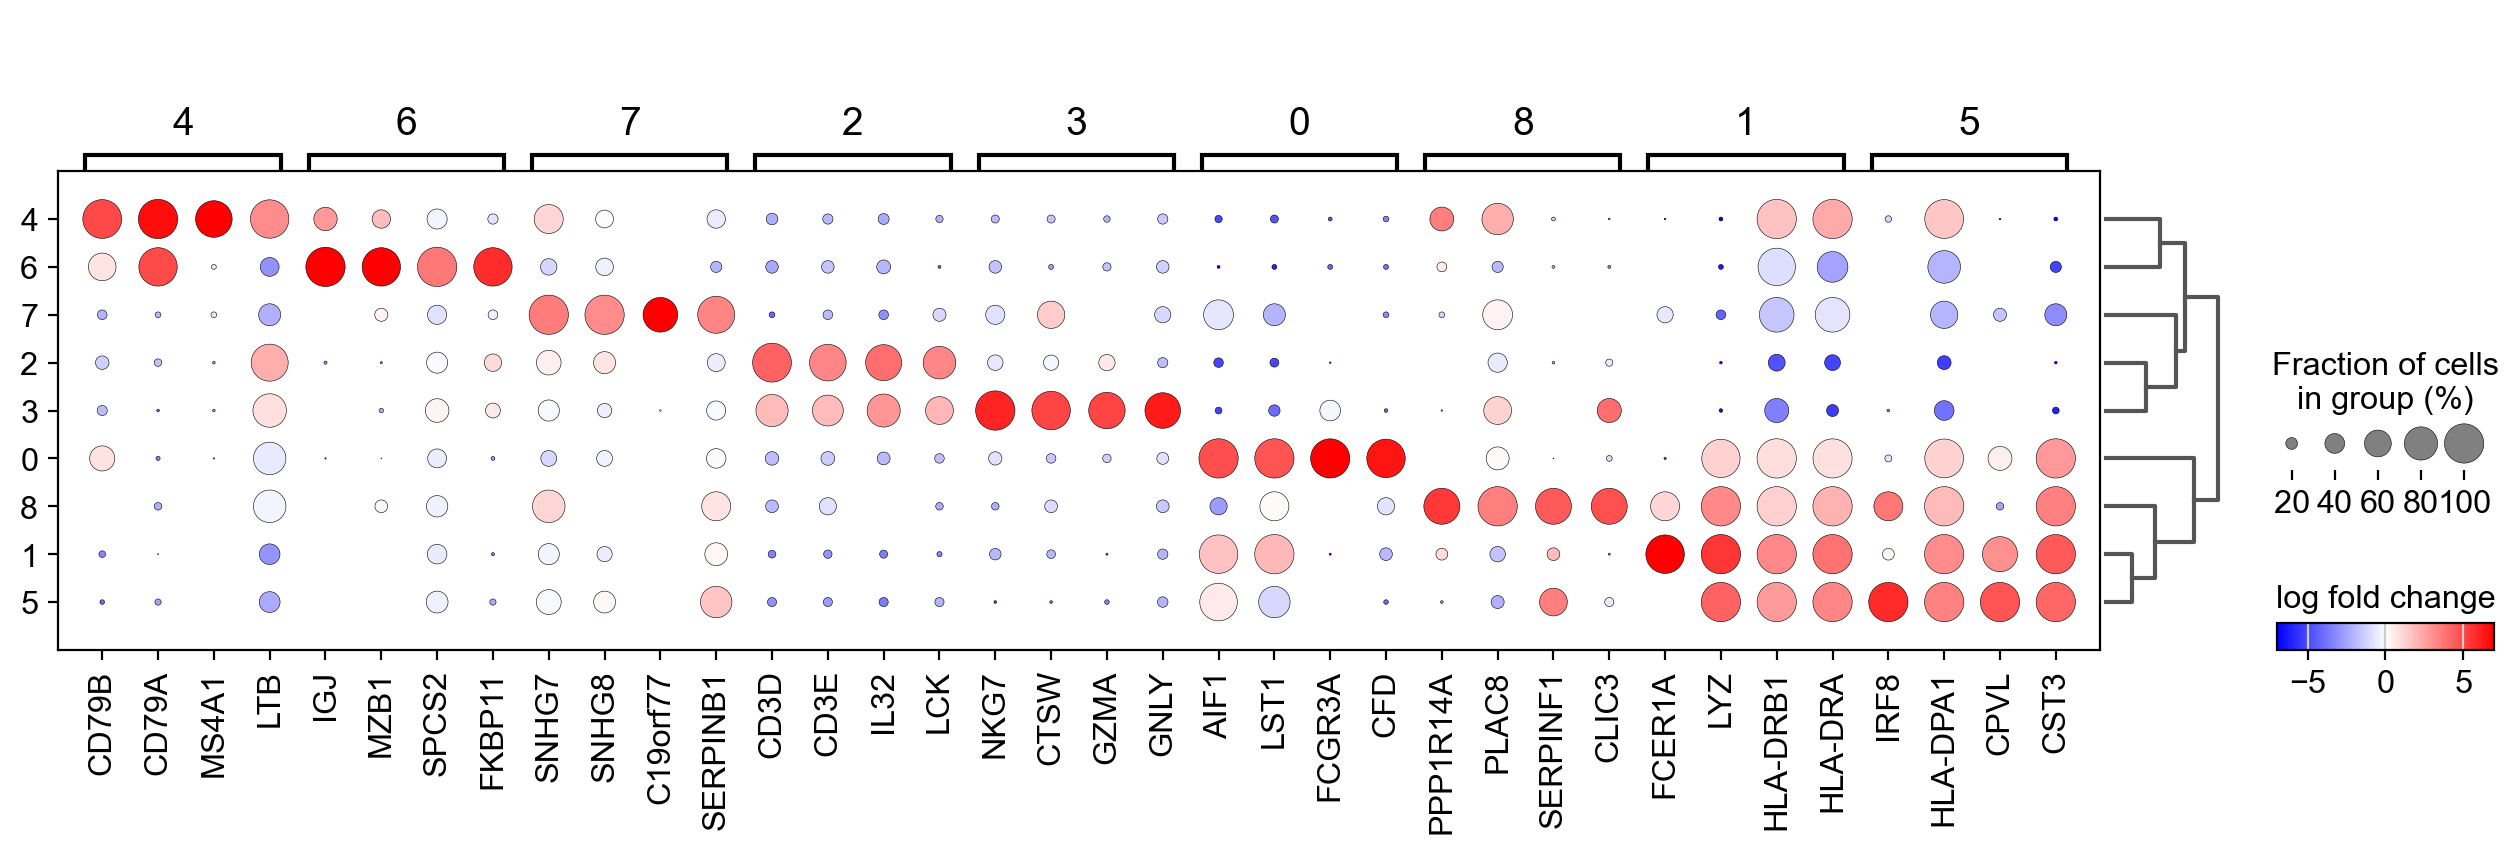

In [34]:
sc.pl.rank_genes_groups_dotplot(
    pbmc,
    n_genes=4,
    values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",
)

#### Focusing on particlar groups

We can choose to only include specific groups in the dotplot using the groups argument

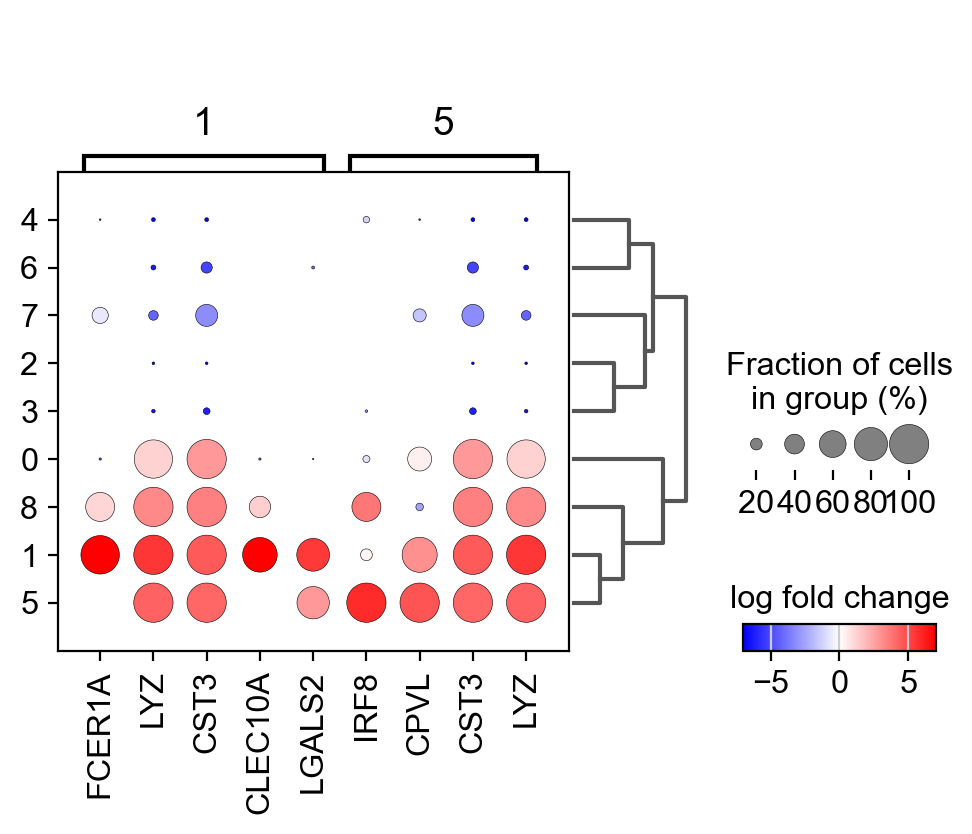

In [37]:
sc.pl.rank_genes_groups_dotplot(
    pbmc,
    n_genes=30,
    values_to_plot="logfoldchanges",
    min_logfoldchange=4,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    groups=["1","5"],
)

#### VIsualizing marker genes using matrixplot

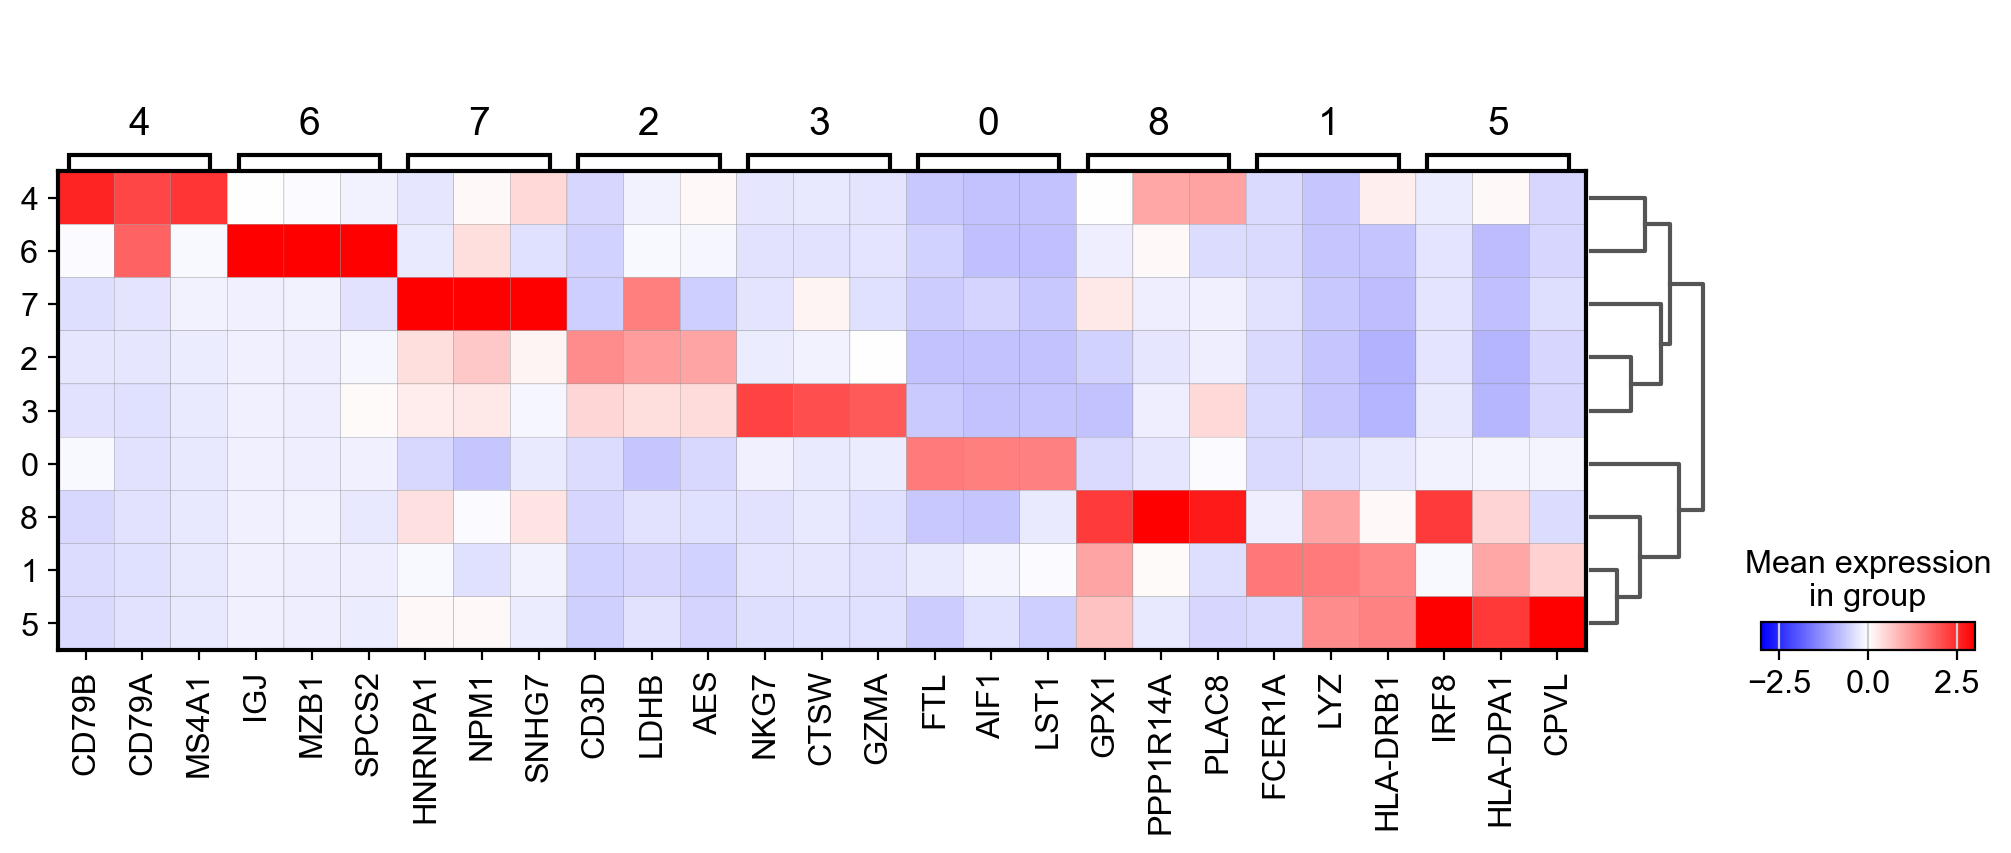

In [39]:
sc.pl.rank_genes_groups_matrixplot(
    pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap="bwr", layer="scaled"
    )

#### Visualize marker genes in stacked violin plot

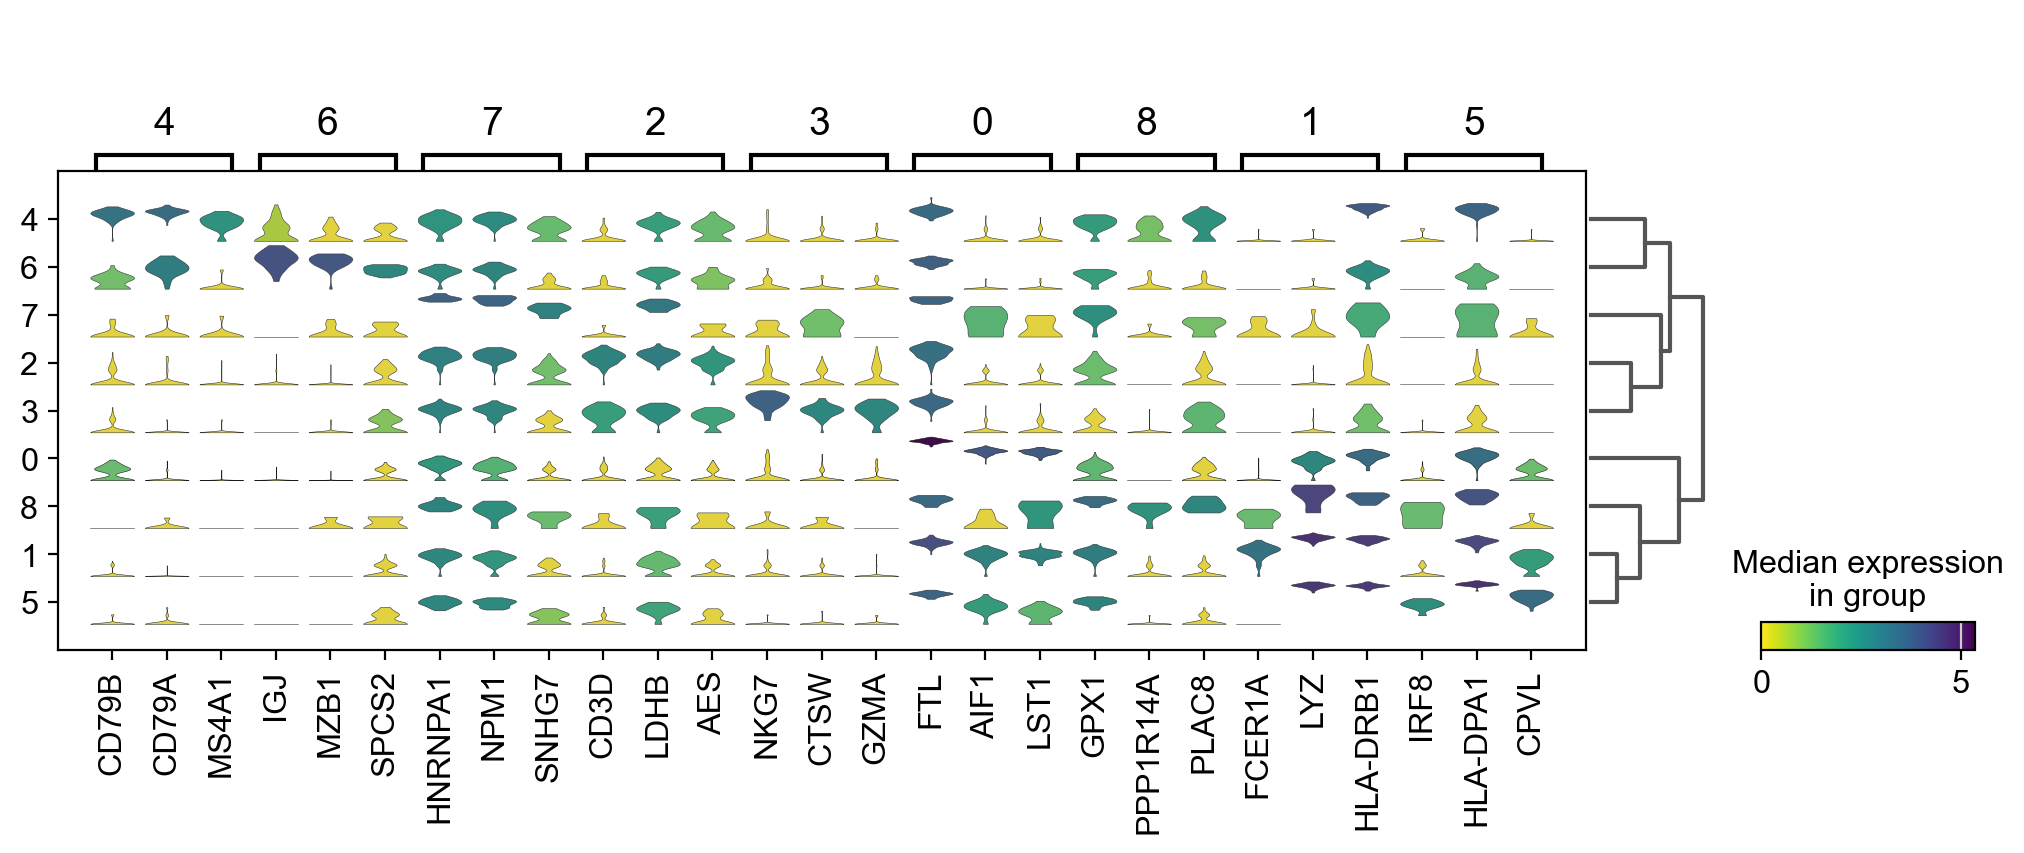

In [40]:
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap="viridis_r")

#### Visualiz marker genes using heatmap

{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: xlabel='clusters'>,
 'dendrogram_ax': <Axes: >,
 'gene_groups_ax': <Axes: >}

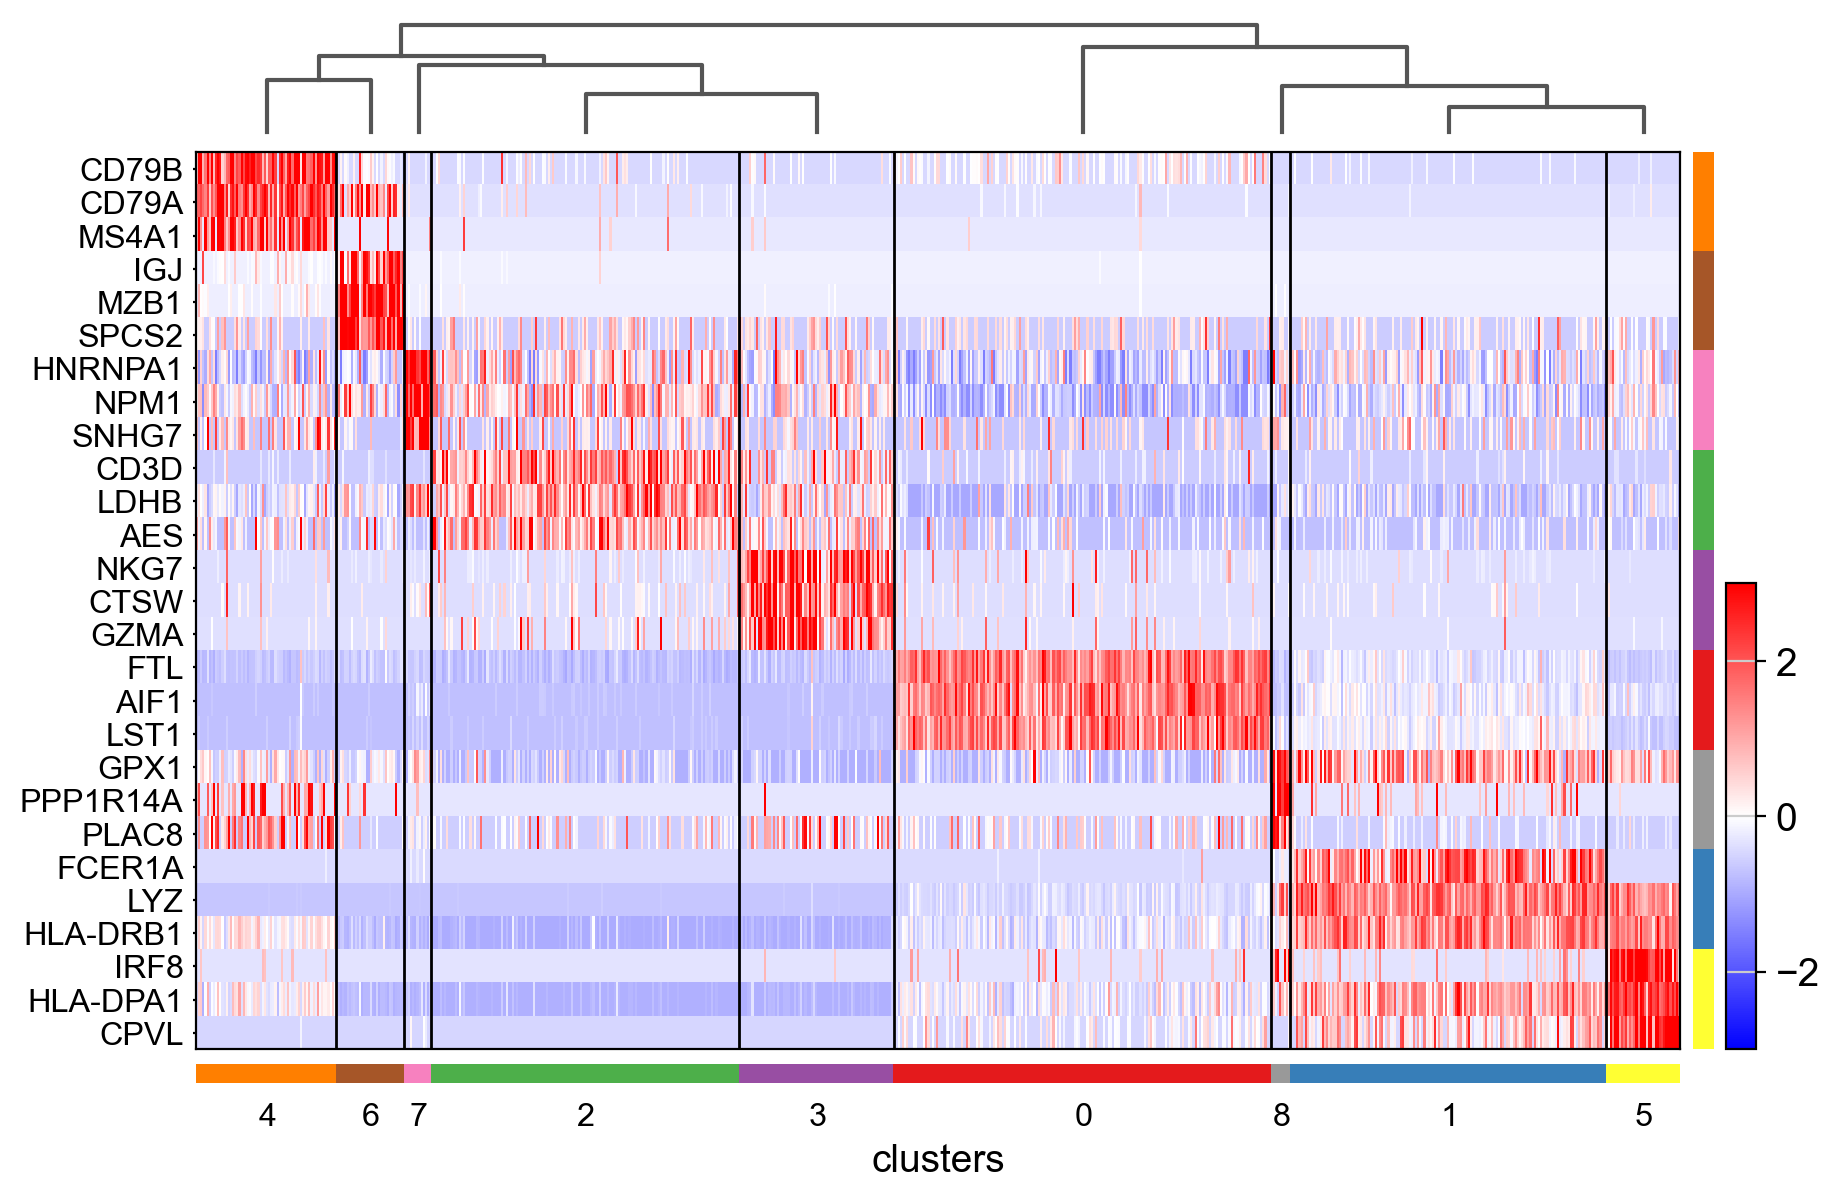

In [41]:
sc.pl.rank_genes_groups_heatmap(
    pbmc,
    n_genes=3,
    use_raw=False,
    swap_axes=True,
    vmin=-3,
    vmax=3,
    cmap="bwr",
    layer="scaled",
    figsize=(10, 7),
    show=False,
)

Showing 10 genes, turning labels off, and swapping axes, a colour code for the categories appears instead of the brackets

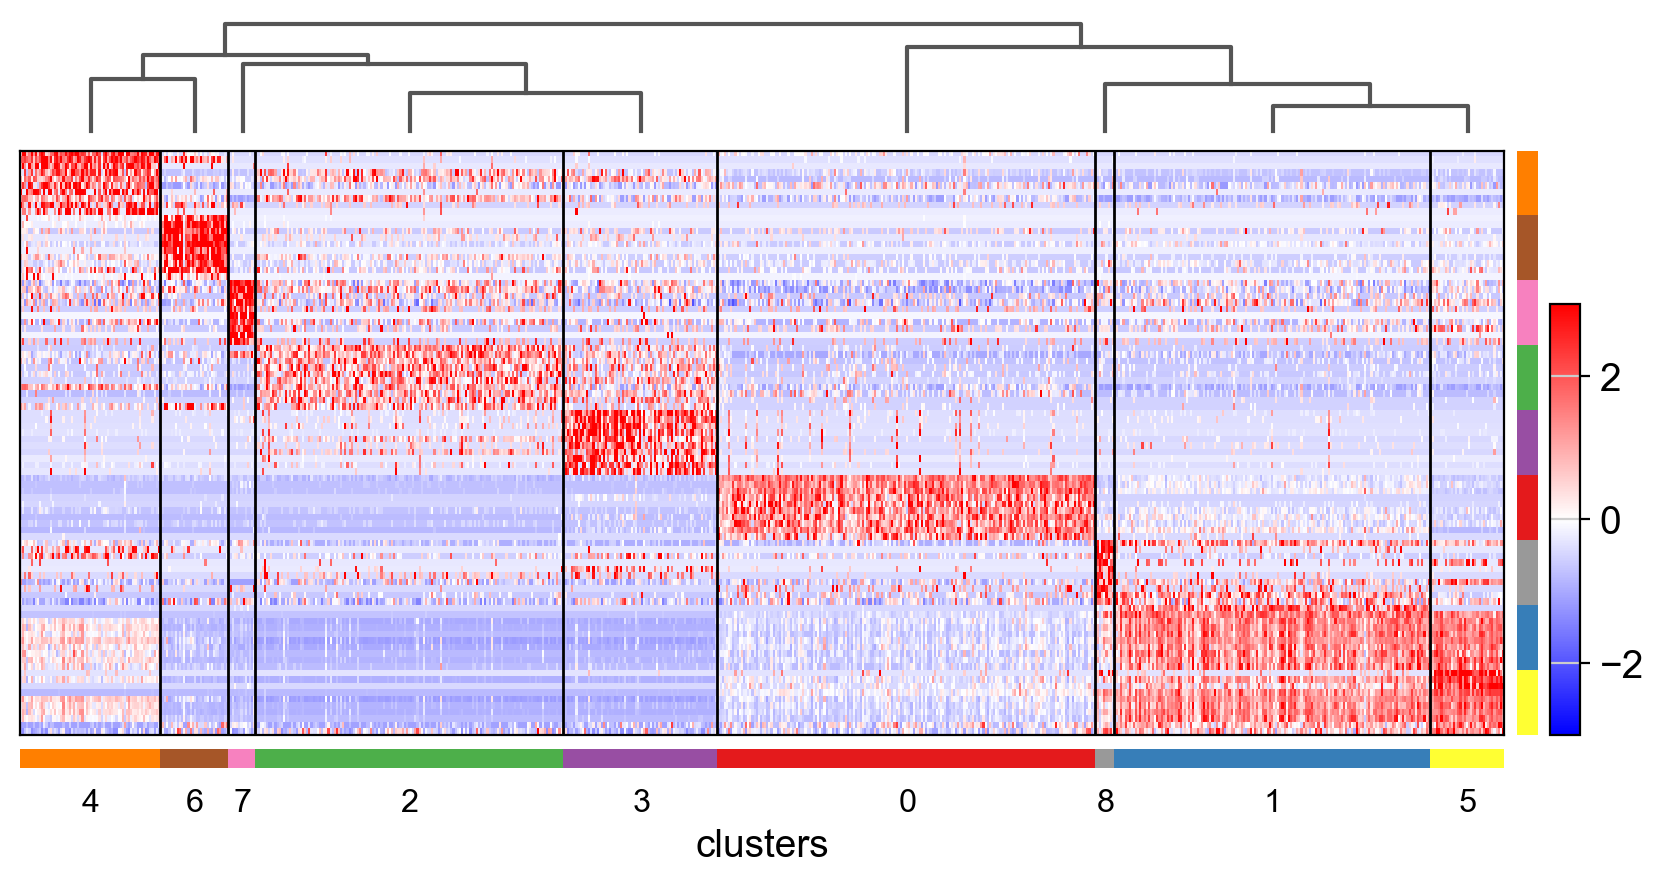

In [42]:
sc.pl.rank_genes_groups_heatmap(
    pbmc,
    n_genes=10,
    use_raw=False,
    swap_axes=True,
    show_gene_labels=False,
    vmin=-3,
    vmax=3,
    cmap="bwr",
)

#### Visualizing marker genes using tracksplot

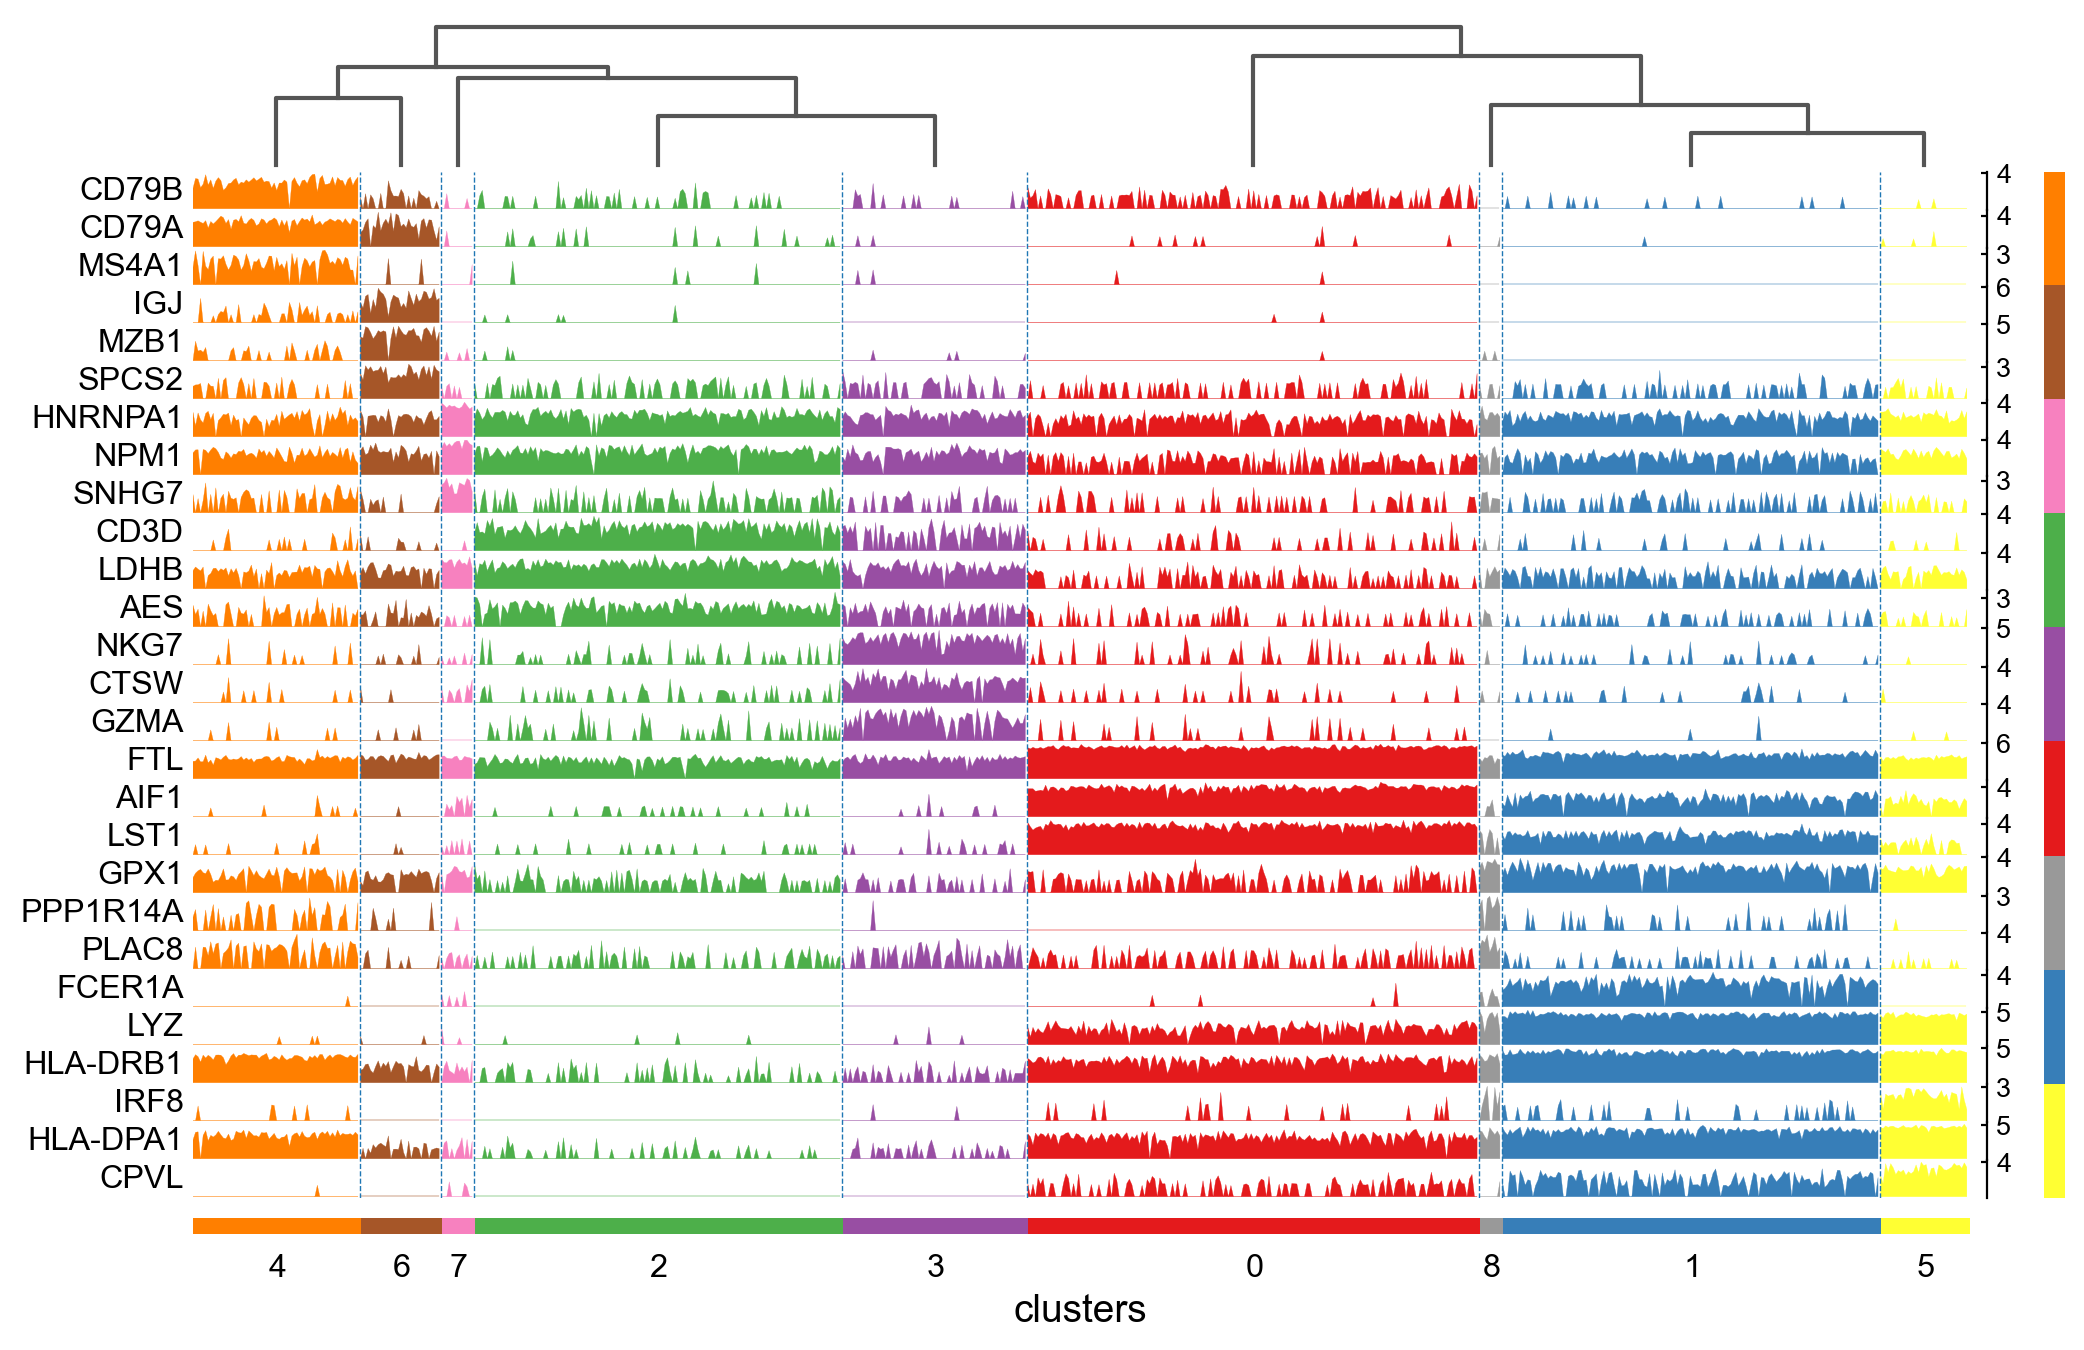

In [43]:
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)

## Comparison of marker genes using split violin plots

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


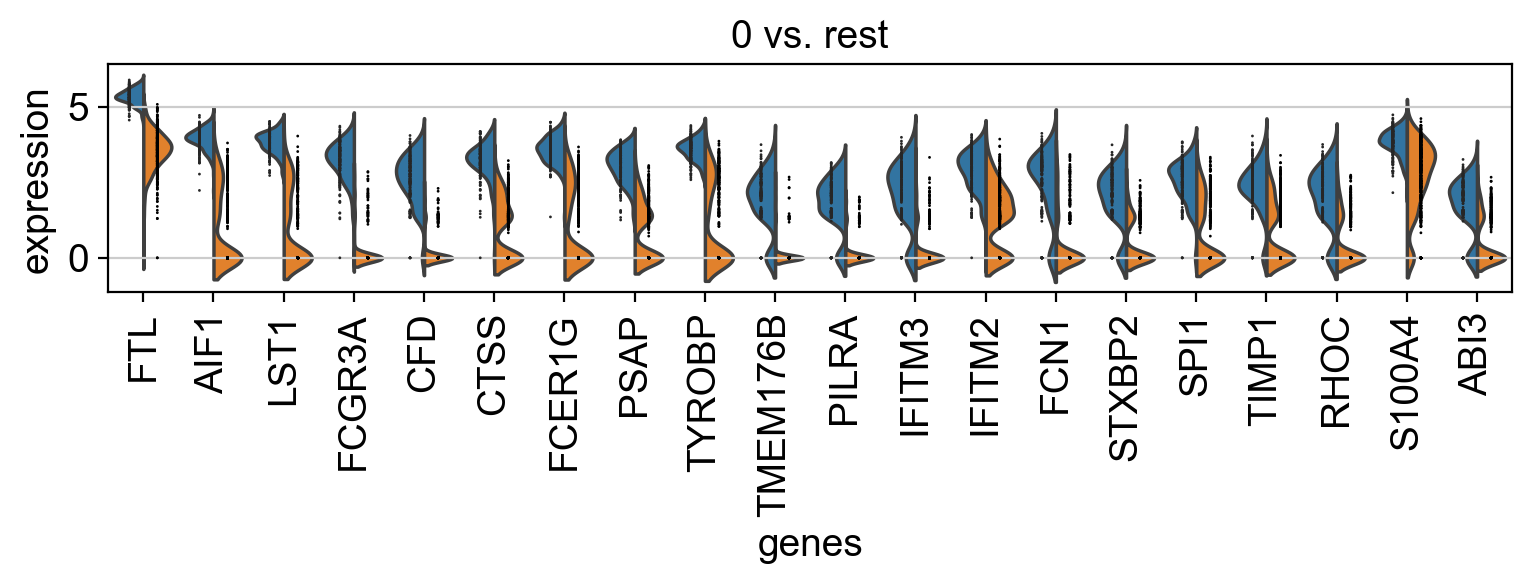

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


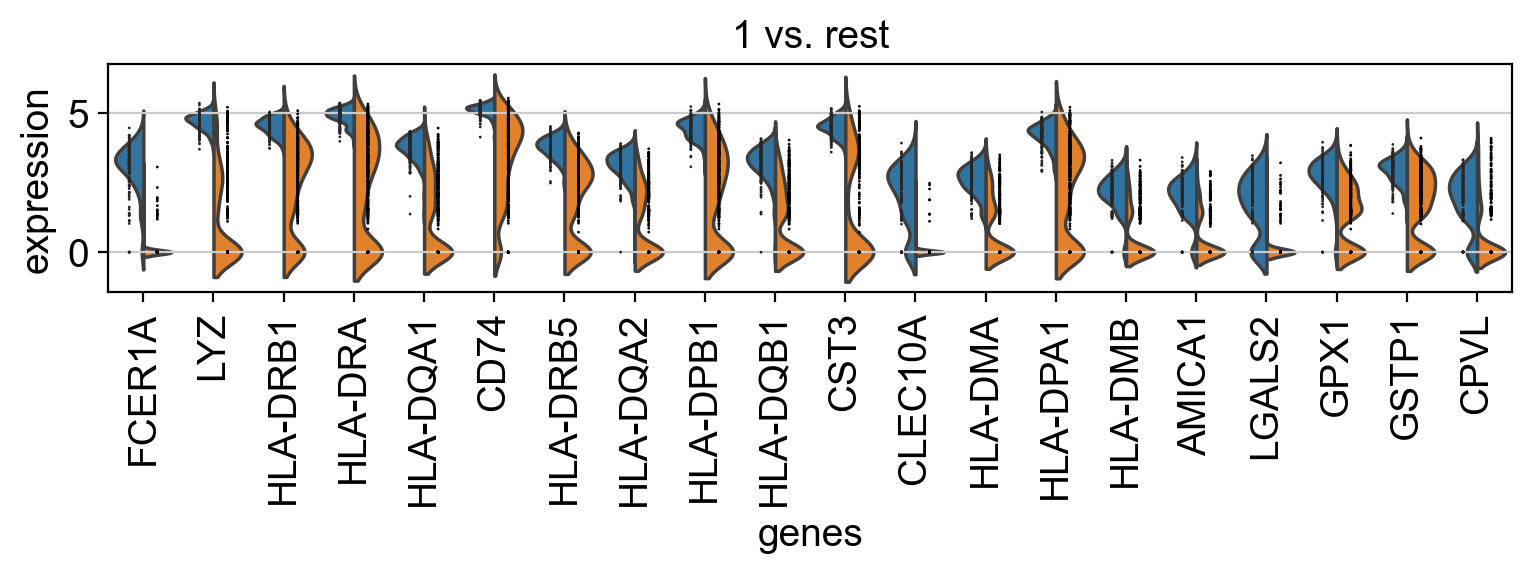

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


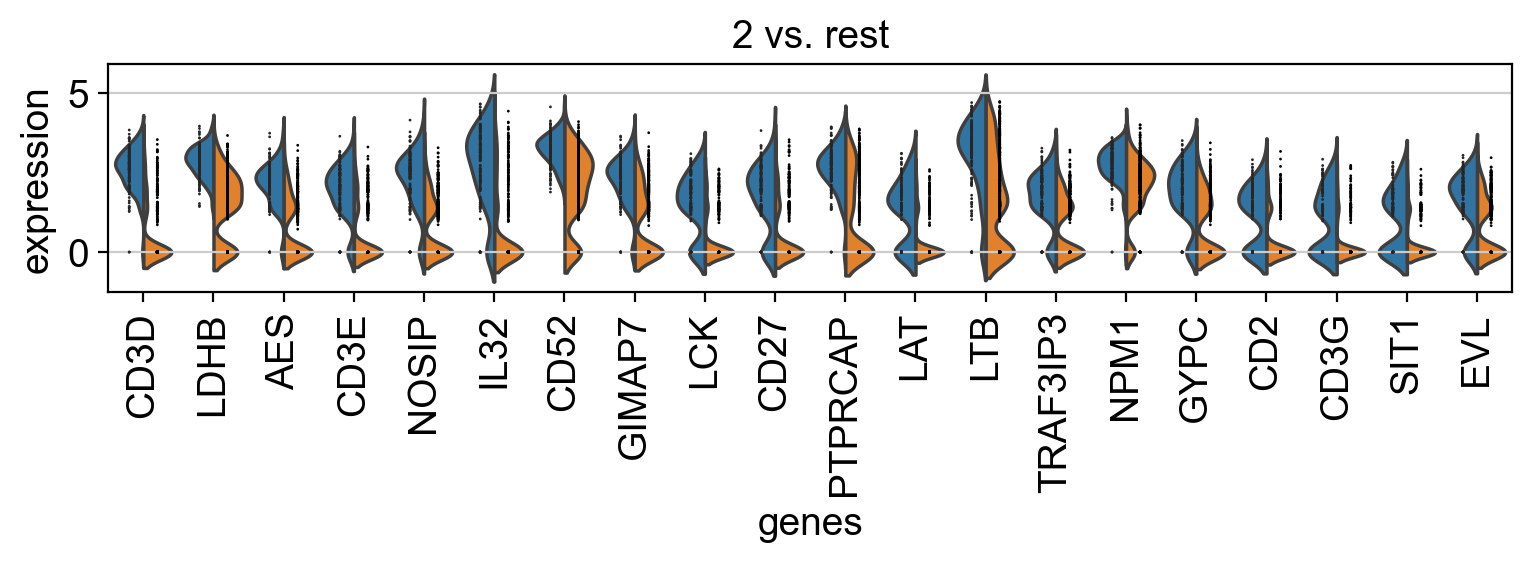

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


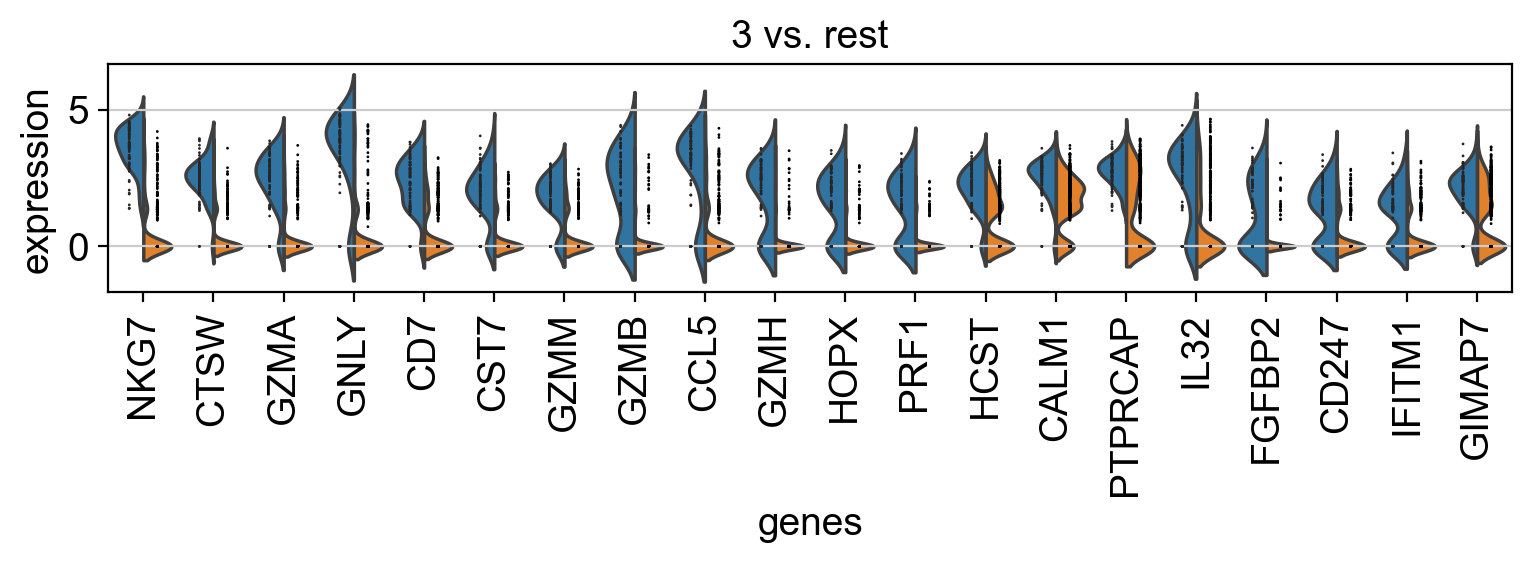

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


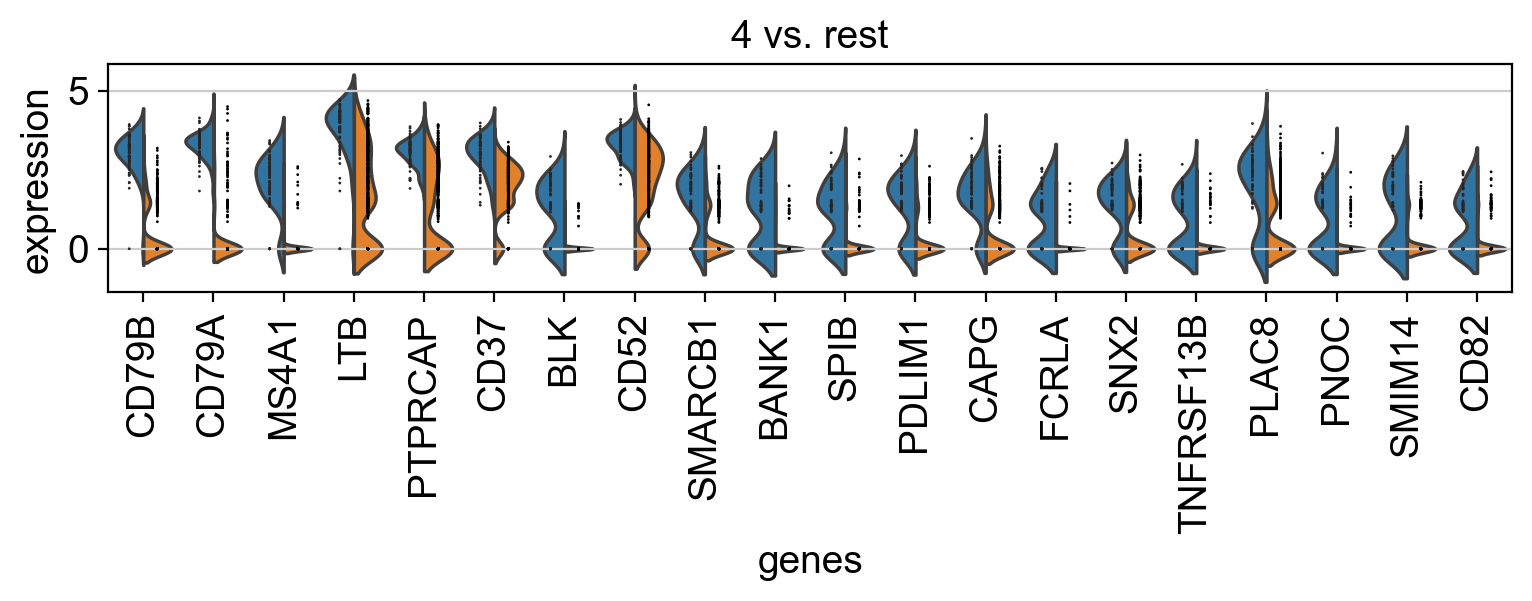

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


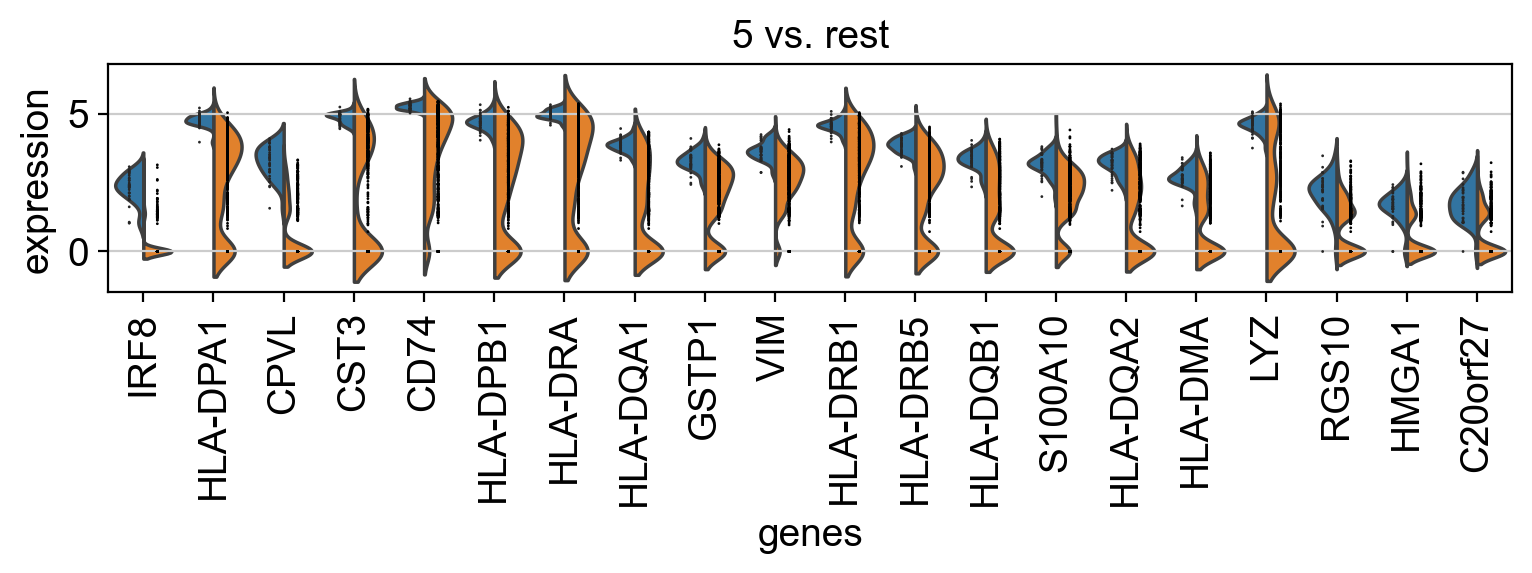

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


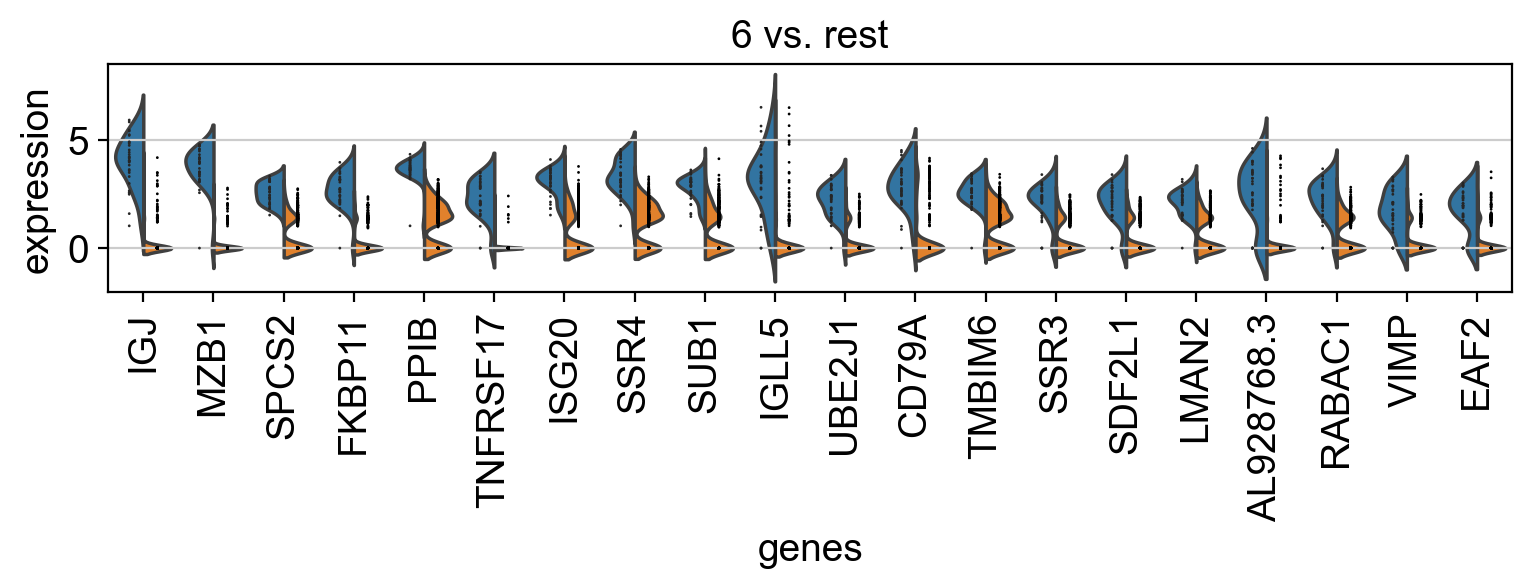

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


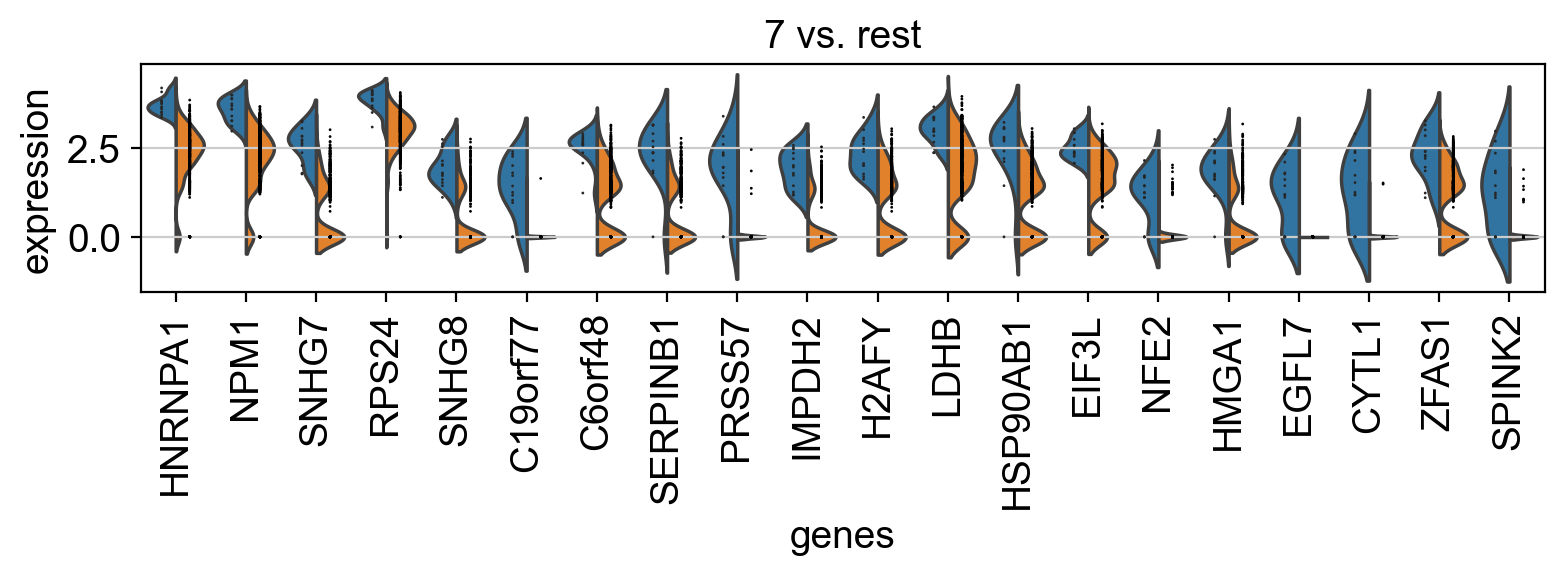

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


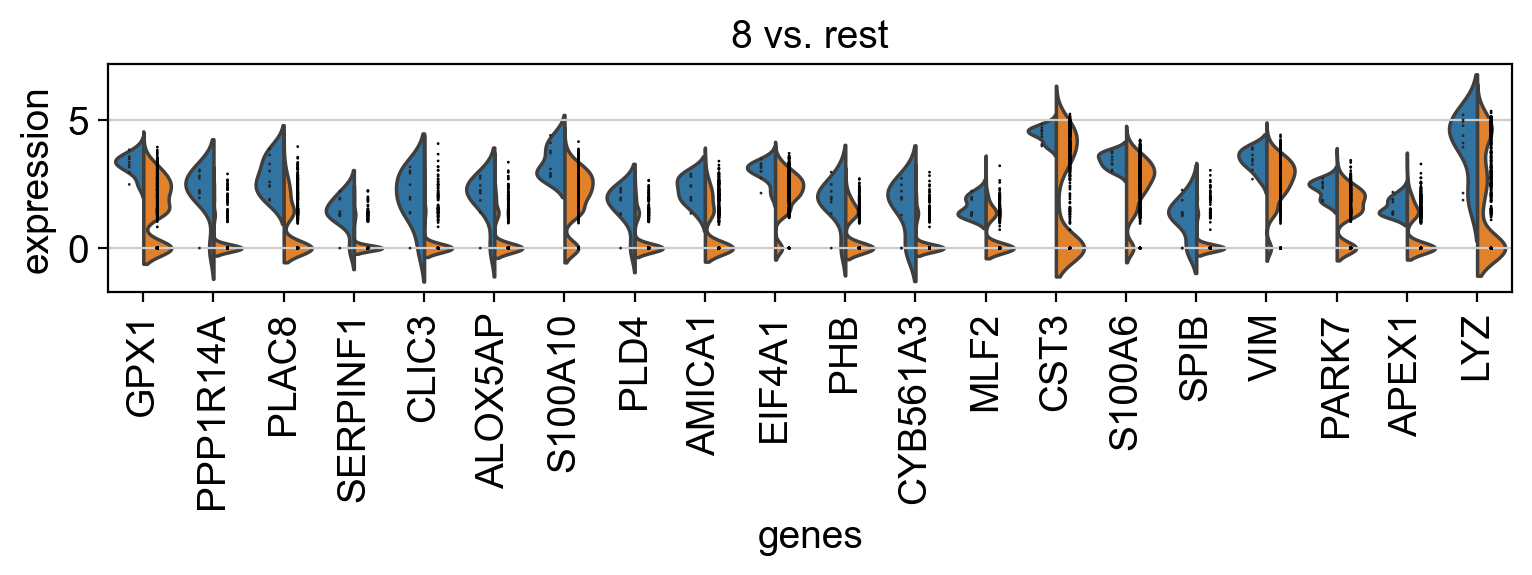

In [44]:
with rc_context({"figure.figsize": (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(pbmc, n_genes=20, jitter=False)

## Dendrogram Options

Most visualizations can arrange categories using a dendrogram

These can also be plotted independantly

In [45]:
#compute heirarchical clustering using PCs
sc.tl.dendrogram(pbmc, "bulk_labels")

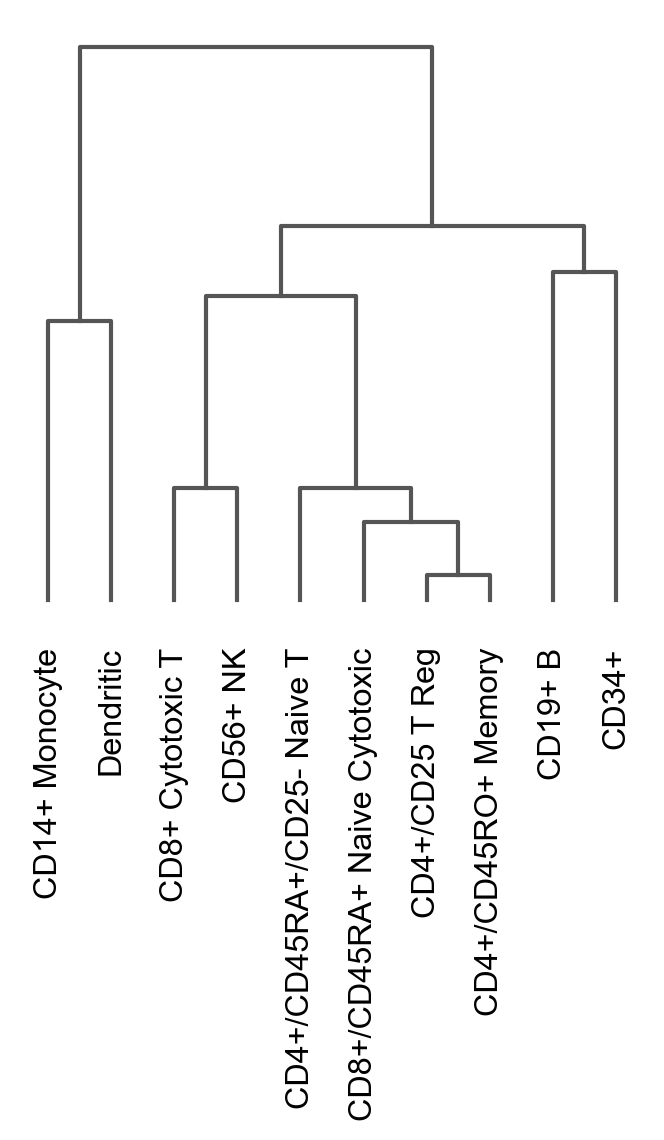

In [46]:
ax = sc.pl.dendrogram(pbmc, "bulk_labels")

## Plot correlation

With the dendrogram it is possible to plot correlation

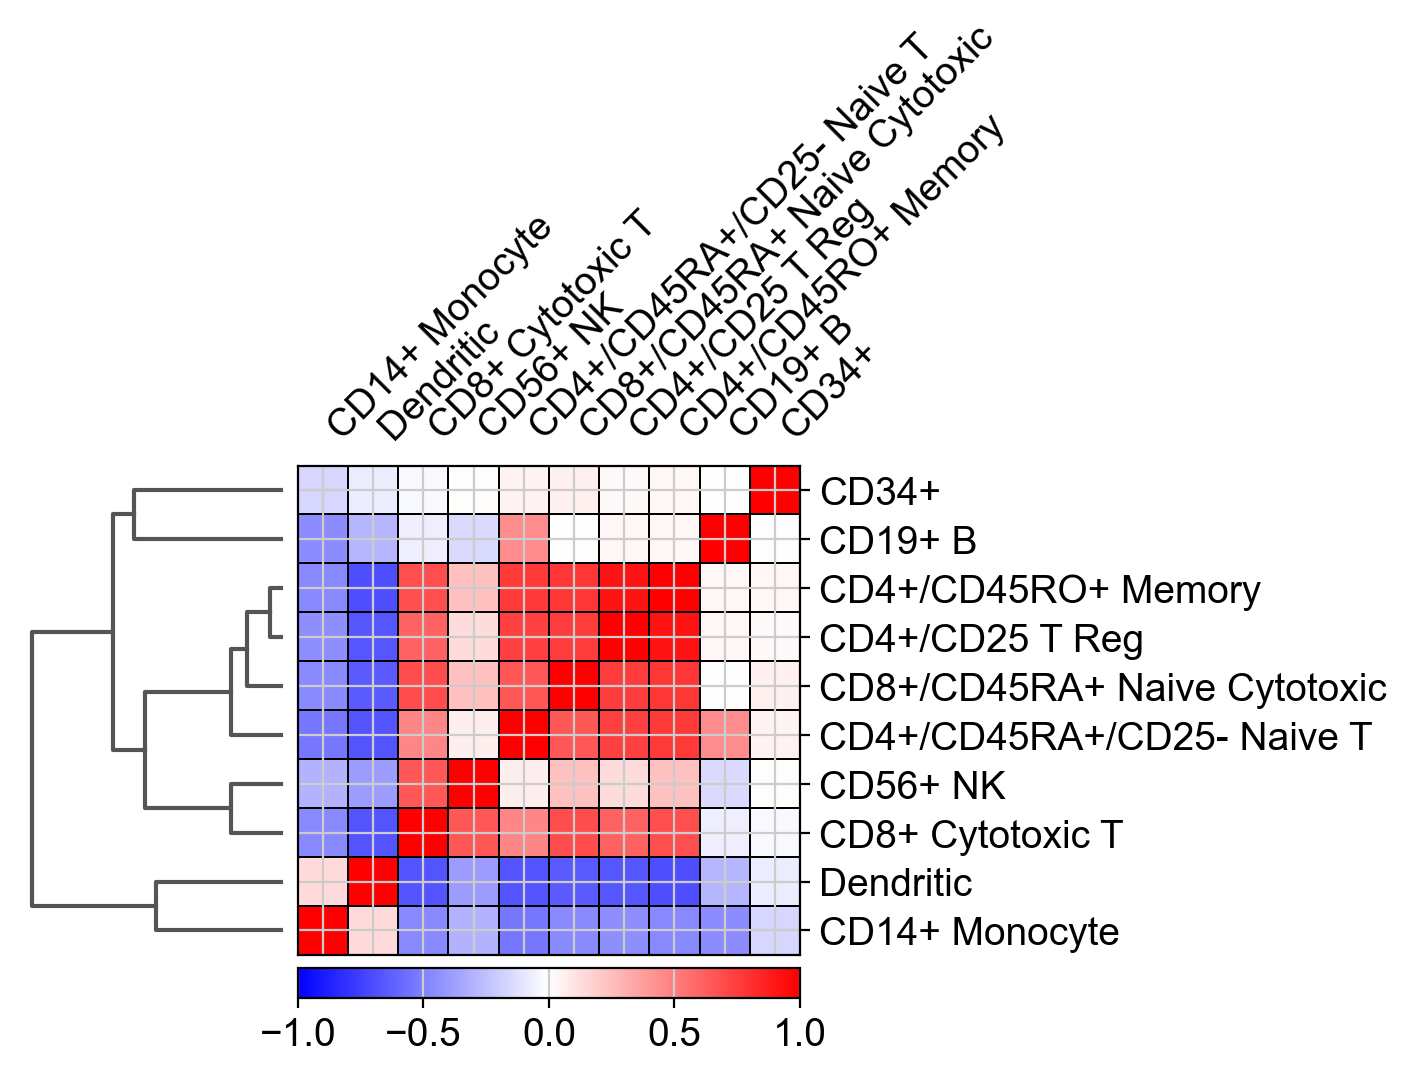

In [47]:
ax = sc.pl.correlation_matrix(pbmc, "bulk_labels", figsize=(5,3.5))